In [1]:
import torch
from torch import nn
import torch.nn.functional as F 
from torch.optim import Adam

import numpy as np
import os
import random
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import pandas as pd
import util
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from time import time
import argparse
from datetime import date
from progressbar import *
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

In [2]:
def train_test_split(X, y, train_ratio=0.8):
    num_ts, num_periods, num_features = X.shape
    train_periods = int(num_periods * train_ratio)
    random.seed(2)
    Xtr = X[:, :train_periods, :]
    ytr = y[:, :train_periods]
    Xte = X[:, train_periods:, :]
    yte = y[:, train_periods:]
    return Xtr, ytr, Xte, yte


In [3]:
class Decoder(nn.Module):

    def __init__(
        self, 
        input_size, 
        output_horizon,
        encoder_hidden_size, 
        decoder_hidden_size, 
        output_size):
        super(Decoder, self).__init__()
        self.global_mlp = nn.Linear(output_horizon * (encoder_hidden_size + input_size), (output_horizon+1) * decoder_hidden_size)
        self.local_mlp = nn.Linear(decoder_hidden_size * 2 + input_size, output_size)
        self.decoder_hidden_size = decoder_hidden_size
    
    def forward(self, ht, xf):
        '''
        Args:
        ht (tensor): (1, hidden_size)
        xf (tensor): (output_horizon, num_features)
        '''
        num_ts, output_horizon, num_features = xf.size()
        num_ts, hidden_size = ht.size()
        ht = ht.unsqueeze(1)
        ht = ht.expand(num_ts, output_horizon, hidden_size)
        # inp = (xf + ht).view(batch_size, -1) # batch_size, hidden_size, output_horizon
        inp = torch.cat([xf, ht], dim=2).view(num_ts, -1)
        contexts = self.global_mlp(inp)
        contexts = contexts.view(num_ts, output_horizon+1, self.decoder_hidden_size)
        ca = contexts[:, -1, :].view(num_ts, -1)
        C = contexts[:, :-1, :]
        C = F.relu(C)
        y = []
        for i in range(output_horizon):
            ci = C[:, i, :].view(num_ts, -1)
            xfi = xf[:, i, :].view(num_ts, -1)
            inp = torch.cat([xfi, ci, ca], dim=1)
            out = self.local_mlp(inp) # num_ts, num_quantiles
            y.append(out.unsqueeze(1))
        y = torch.cat(y, dim=1) # batch_size, output_horizon, quantiles
        return y 


class MQRNN(nn.Module):

    def __init__(self, output_horizon, num_quantiles, input_size, embedding_size=10,
        encoder_hidden_size=64, encoder_n_layers=3, decoder_hidden_size=64):
        '''
        Args:
        output_horizon (int): output horizons to output in prediction
        num_quantiles (int): number of quantiles interests, e.g. 0.25, 0.5, 0.75
        input_size (int): feature size
        embedding_size (int): embedding size
        encoder_hidden_size (int): hidden size in encoder
        encoder_n_layers (int): encoder number of layers
        decoder_hidden_size (int): hidden size in decoder
        '''
        super(MQRNN, self).__init__()
        self.output_horizon = output_horizon
        self.encoder_hidden_size = encoder_hidden_size
        self.input_embed = nn.Linear(1, embedding_size) # time series embedding
        self.encoder = nn.LSTM(input_size + embedding_size, encoder_hidden_size, encoder_n_layers, bias=True, batch_first=True)
        self.decoder = Decoder(input_size, output_horizon, encoder_hidden_size, decoder_hidden_size, num_quantiles)
    
    def forward(self, X, y, Xf):
        '''
        Args:
        X (tensor like): shape (num_time_series, num_periods, num_features)
        y (tensor like): shape (num_time_series, num_periods)
        Xf (tensor like): shape (num_time_series, seq_len, num_features)
        '''
        if isinstance(X, type(np.empty(2))):
            X = torch.from_numpy(X).float()
            y = torch.from_numpy(y).float()
            Xf = torch.from_numpy(Xf).float()
        num_ts, num_periods, num_features = X.size()
        y = y.unsqueeze(2)
        y = self.input_embed(y)
        x = torch.cat([X, y], dim=2)
        # x = x.unsqueeze(0) # batch, seq_len, embed + num_features
        _, (h, c) = self.encoder(x)
        ht = h[-1, :, :]
        # global mlp
        ht = F.relu(ht)
        ypred = self.decoder(ht, Xf)
        return ypred

    
def batch_generator(X, y, num_obs_to_train, seq_len, batch_size):
    '''
    Args:
    X (array like): shape (num_samples, num_features, num_periods)
    y (array like): shape (num_samples, num_periods)
    num_obs_to_train (int)
    seq_len (int): sequence/encoder/decoder length
    '''
    num_ts, num_periods, _ = X.shape
    #print(X.shape)
    if num_ts < batch_size:
        batch_size = num_ts
    t = random.choice(range(num_obs_to_train, num_periods-seq_len))
    
    batch = random.sample(range(num_ts), batch_size)
    X_train_batch = X[batch, t-num_obs_to_train:t, :]
    y_train_batch = y[batch, t-num_obs_to_train:t]
    Xf = X[batch, t:t+seq_len, :]
    yf = y[batch, t:t+seq_len]
    
    return X_train_batch, y_train_batch, Xf, yf

In [4]:
def train(X, y, quantiles):
    num_ts, num_periods, num_features = X.shape
    num_quantiles = len(quantiles)
    model = MQRNN(seq_len, num_quantiles, num_features, embedding_size, encoder_hidden_size, n_layers, decoder_hidden_size)
    optimizer = Adam(model.parameters(), lr=lr)
    
    Xtr, ytr, Xte, yte = train_test_split(X, y)
    print(Xtr.shape, ytr.shape, Xte.shape, yte.shape)
    
    
    losses = []
    mape_list, mae_list, rmse_list = [], [], []
    
    yscaler = None
    if standard_scaler:
        yscaler = util.StandardScaler()
    elif log_scaler:
        yscaler = util.LogScaler()
    elif mean_scaler:
        yscaler = util.MeanScaler()
    if yscaler is not None:
        ytr = yscaler.fit_transform(ytr)
    
    
    ####################  train  ####################
    progress = ProgressBar()
    for epoch in progress(range(num_epoches)):
        print("Epoch {} start...".format(epoch))
        for step in range(step_per_epoch):
            X_train_batch, y_train_batch, Xf, yf = batch_generator(Xtr, ytr, num_obs_to_train, seq_len, batch_size)

            X_train_tensor = torch.from_numpy(X_train_batch).float()
            y_train_tensor = torch.from_numpy(y_train_batch).float() 

            Xf = torch.from_numpy(Xf).float()
            yf = torch.from_numpy(yf).float()
            ypred = model(X_train_tensor, y_train_tensor, Xf)

            # quantile loss
            loss = torch.zeros_like(yf)
            num_ts = Xf.size(0)
            for q, rho in enumerate(quantiles):
                ypred_rho = ypred[:, :, q].view(num_ts, -1)
                e = ypred_rho - yf
                loss += torch.max(rho * e, (rho - 1) * e)
            loss = loss.mean()

            losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    ####################  test  ####################
    for i in range(Xte.shape[1]-num_obs_to_train-seq_len):
        print("Prediction:", i)
    
        X_test = Xte[:, i:i+num_obs_to_train, :].reshape((num_ts, -1, num_features))
        Xf_test = Xte[:, i+num_obs_to_train:i+num_obs_to_train+seq_len, :].reshape((num_ts, -1, num_features))
        y_test = yte[:, i:i+num_obs_to_train].reshape((num_ts, -1))

        if yscaler is not None:
            y_test = yscaler.transform(y_test)
        yf_test = yte[:, i+num_obs_to_train:i+num_obs_to_train+seq_len]

        ypred = model(X_test, y_test, Xf_test) # (1, num_quantiles, output_horizon)
        ypred = ypred.data.numpy()
        ypred = yscaler.inverse_transform(ypred)
        
        # P50 quantile MAPE 
        mape = util.MAPE(yf_test, ypred[:, :, 1])
        mape_list.append(mape)
#         print("MAPE: {}".format(mape))

        mae = MAE(ypred[:, :, 1], yf_test)
        mae_list.append(mae)
#         print("MAE: {}".format(mae))

        rmse = np.sqrt(MSE(ypred[:, :, 1], yf_test))
        rmse_list.append(rmse)
#         print("RMSE: {}".format(rmse))
    
    return losses, mape_list, mae_list, rmse_list

In [5]:
num_epoches = 500   # 28050*10
step_per_epoch = 3
lr = 1e-3
batch_size = 256
n_layers = 3
encoder_hidden_size = 64
decoder_hidden_size = 64
seq_len = 12
num_obs_to_train = 24*3
embedding_size = 24
standard_scaler = True

In [6]:
#if args.run_test:
# data_path = util.get_data_path()
dataset = pd.read_csv("../../../data/Merged-update_hourly.csv")
dataset.fillna(0, inplace=True)
dataset = dataset.iloc[:, :]
print(dataset.shape)
print(dataset.columns)

(96432, 20)
Index(['Time', 'WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A',
       'TWS_S25A', 'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B',
       'TWS_S25B', 'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2',
       'HWS_S26', 'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


X.shape, y.shape: (8, 12054, 15) (8, 12054)
(8, 9643, 15) (8, 9643) (8, 2411, 15) (8, 2411)
Epoch 0 start...
Epoch 1 start...
Epoch 2 start...
Epoch 3 start...


Epoch 4 start...
Epoch 5 start...
Epoch 6 start...
Epoch 7 start...


Epoch 8 start...
Epoch 9 start...
Epoch 10 start...
Epoch 11 start...


Epoch 12 start...
Epoch 13 start...
Epoch 14 start...
Epoch 15 start...


Epoch 16 start...
Epoch 17 start...
Epoch 18 start...
Epoch 19 start...


Epoch 20 start...
Epoch 21 start...
Epoch 22 start...
Epoch 23 start...


Epoch 24 start...
Epoch 25 start...
Epoch 26 start...
Epoch 27 start...


Epoch 28 start...
Epoch 29 start...
Epoch 30 start...
Epoch 31 start...


Epoch 32 start...
Epoch 33 start...
Epoch 34 start...
Epoch 35 start...


Epoch 36 start...
Epoch 37 start...
Epoch 38 start...
Epoch 39 start...


Epoch 40 start...
Epoch 41 start...
Epoch 42 start...
Epoch 43 start...


Epoch 44 start...
Epoch 45 start...
Epoch 46 start...
Epoch 47 start...


Epoch 48 start...
Epoch 49 start...
Epoch 50 start...
Epoch 51 start...


Epoch 52 start...
Epoch 53 start...
Epoch 54 start...
Epoch 55 start...


Epoch 56 start...
Epoch 57 start...
Epoch 58 start...
Epoch 59 start...


Epoch 60 start...
Epoch 61 start...
Epoch 62 start...
Epoch 63 start...


Epoch 64 start...
Epoch 65 start...
Epoch 66 start...
Epoch 67 start...


Epoch 68 start...
Epoch 69 start...
Epoch 70 start...
Epoch 71 start...


Epoch 72 start...
Epoch 73 start...
Epoch 74 start...
Epoch 75 start...


Epoch 76 start...
Epoch 77 start...
Epoch 78 start...
Epoch 79 start...


Epoch 80 start...
Epoch 81 start...
Epoch 82 start...
Epoch 83 start...


Epoch 84 start...
Epoch 85 start...
Epoch 86 start...
Epoch 87 start...


Epoch 88 start...
Epoch 89 start...
Epoch 90 start...
Epoch 91 start...


Epoch 92 start...
Epoch 93 start...
Epoch 94 start...
Epoch 95 start...


Epoch 96 start...
Epoch 97 start...
Epoch 98 start...
Epoch 99 start...


Epoch 100 start...
Epoch 101 start...
Epoch 102 start...
Epoch 103 start...


Epoch 104 start...
Epoch 105 start...
Epoch 106 start...
Epoch 107 start...


Epoch 108 start...
Epoch 109 start...
Epoch 110 start...
Epoch 111 start...


Epoch 112 start...
Epoch 113 start...
Epoch 114 start...
Epoch 115 start...


Epoch 116 start...
Epoch 117 start...
Epoch 118 start...
Epoch 119 start...


Epoch 120 start...
Epoch 121 start...
Epoch 122 start...
Epoch 123 start...


Epoch 124 start...
Epoch 125 start...
Epoch 126 start...
Epoch 127 start...


Epoch 128 start...
Epoch 129 start...
Epoch 130 start...
Epoch 131 start...


Epoch 132 start...
Epoch 133 start...
Epoch 134 start...
Epoch 135 start...


Epoch 136 start...
Epoch 137 start...
Epoch 138 start...
Epoch 139 start...


Epoch 140 start...
Epoch 141 start...
Epoch 142 start...
Epoch 143 start...


Epoch 144 start...
Epoch 145 start...
Epoch 146 start...
Epoch 147 start...


Epoch 148 start...
Epoch 149 start...
Epoch 150 start...
Epoch 151 start...


Epoch 152 start...
Epoch 153 start...
Epoch 154 start...
Epoch 155 start...


Epoch 156 start...
Epoch 157 start...
Epoch 158 start...
Epoch 159 start...


Epoch 160 start...
Epoch 161 start...
Epoch 162 start...
Epoch 163 start...


Epoch 164 start...
Epoch 165 start...
Epoch 166 start...
Epoch 167 start...


Epoch 168 start...
Epoch 169 start...
Epoch 170 start...
Epoch 171 start...


Epoch 172 start...
Epoch 173 start...
Epoch 174 start...
Epoch 175 start...


Epoch 176 start...
Epoch 177 start...
Epoch 178 start...
Epoch 179 start...


Epoch 180 start...
Epoch 181 start...
Epoch 182 start...
Epoch 183 start...


Epoch 184 start...
Epoch 185 start...
Epoch 186 start...
Epoch 187 start...


Epoch 188 start...
Epoch 189 start...
Epoch 190 start...
Epoch 191 start...


Epoch 192 start...
Epoch 193 start...
Epoch 194 start...
Epoch 195 start...


Epoch 196 start...
Epoch 197 start...
Epoch 198 start...
Epoch 199 start...


Epoch 200 start...
Epoch 201 start...
Epoch 202 start...
Epoch 203 start...


Epoch 204 start...
Epoch 205 start...
Epoch 206 start...
Epoch 207 start...


Epoch 208 start...
Epoch 209 start...
Epoch 210 start...
Epoch 211 start...


Epoch 212 start...
Epoch 213 start...
Epoch 214 start...
Epoch 215 start...


Epoch 216 start...
Epoch 217 start...
Epoch 218 start...
Epoch 219 start...


Epoch 220 start...
Epoch 221 start...
Epoch 222 start...
Epoch 223 start...


Epoch 224 start...
Epoch 225 start...
Epoch 226 start...
Epoch 227 start...


Epoch 228 start...
Epoch 229 start...
Epoch 230 start...
Epoch 231 start...


Epoch 232 start...
Epoch 233 start...
Epoch 234 start...
Epoch 235 start...


Epoch 236 start...
Epoch 237 start...
Epoch 238 start...
Epoch 239 start...


Epoch 240 start...
Epoch 241 start...
Epoch 242 start...
Epoch 243 start...


Epoch 244 start...
Epoch 245 start...
Epoch 246 start...
Epoch 247 start...


Epoch 248 start...
Epoch 249 start...
Epoch 250 start...
Epoch 251 start...


Epoch 252 start...
Epoch 253 start...
Epoch 254 start...
Epoch 255 start...


Epoch 256 start...
Epoch 257 start...
Epoch 258 start...
Epoch 259 start...


Epoch 260 start...
Epoch 261 start...
Epoch 262 start...
Epoch 263 start...


Epoch 264 start...
Epoch 265 start...
Epoch 266 start...
Epoch 267 start...


Epoch 268 start...
Epoch 269 start...
Epoch 270 start...
Epoch 271 start...


Epoch 272 start...
Epoch 273 start...
Epoch 274 start...
Epoch 275 start...


Epoch 276 start...
Epoch 277 start...
Epoch 278 start...
Epoch 279 start...


Epoch 280 start...
Epoch 281 start...
Epoch 282 start...
Epoch 283 start...


Epoch 284 start...
Epoch 285 start...
Epoch 286 start...
Epoch 287 start...


Epoch 288 start...
Epoch 289 start...
Epoch 290 start...
Epoch 291 start...


Epoch 292 start...
Epoch 293 start...
Epoch 294 start...
Epoch 295 start...


Epoch 296 start...
Epoch 297 start...
Epoch 298 start...
Epoch 299 start...


Epoch 300 start...
Epoch 301 start...
Epoch 302 start...
Epoch 303 start...


Epoch 304 start...
Epoch 305 start...
Epoch 306 start...
Epoch 307 start...


Epoch 308 start...
Epoch 309 start...
Epoch 310 start...
Epoch 311 start...


Epoch 312 start...
Epoch 313 start...
Epoch 314 start...
Epoch 315 start...


Epoch 316 start...
Epoch 317 start...
Epoch 318 start...
Epoch 319 start...


Epoch 320 start...
Epoch 321 start...
Epoch 322 start...
Epoch 323 start...


Epoch 324 start...
Epoch 325 start...
Epoch 326 start...
Epoch 327 start...


Epoch 328 start...
Epoch 329 start...
Epoch 330 start...
Epoch 331 start...


Epoch 332 start...
Epoch 333 start...
Epoch 334 start...
Epoch 335 start...


Epoch 336 start...
Epoch 337 start...
Epoch 338 start...
Epoch 339 start...


Epoch 340 start...
Epoch 341 start...
Epoch 342 start...
Epoch 343 start...


Epoch 344 start...
Epoch 345 start...
Epoch 346 start...
Epoch 347 start...


Epoch 348 start...
Epoch 349 start...
Epoch 350 start...
Epoch 351 start...


Epoch 352 start...
Epoch 353 start...
Epoch 354 start...
Epoch 355 start...


Epoch 356 start...
Epoch 357 start...
Epoch 358 start...
Epoch 359 start...


Epoch 360 start...
Epoch 361 start...
Epoch 362 start...
Epoch 363 start...


Epoch 364 start...
Epoch 365 start...
Epoch 366 start...
Epoch 367 start...


Epoch 368 start...
Epoch 369 start...
Epoch 370 start...
Epoch 371 start...


Epoch 372 start...
Epoch 373 start...
Epoch 374 start...
Epoch 375 start...


Epoch 376 start...
Epoch 377 start...
Epoch 378 start...
Epoch 379 start...


Epoch 380 start...
Epoch 381 start...
Epoch 382 start...
Epoch 383 start...


Epoch 384 start...
Epoch 385 start...
Epoch 386 start...
Epoch 387 start...


Epoch 388 start...
Epoch 389 start...
Epoch 390 start...
Epoch 391 start...


Epoch 392 start...
Epoch 393 start...
Epoch 394 start...
Epoch 395 start...


Epoch 396 start...
Epoch 397 start...
Epoch 398 start...
Epoch 399 start...


Epoch 400 start...
Epoch 401 start...
Epoch 402 start...
Epoch 403 start...


Epoch 404 start...
Epoch 405 start...
Epoch 406 start...
Epoch 407 start...


Epoch 408 start...
Epoch 409 start...
Epoch 410 start...
Epoch 411 start...


Epoch 412 start...
Epoch 413 start...
Epoch 414 start...
Epoch 415 start...


Epoch 416 start...
Epoch 417 start...
Epoch 418 start...
Epoch 419 start...


Epoch 420 start...
Epoch 421 start...
Epoch 422 start...
Epoch 423 start...


Epoch 424 start...
Epoch 425 start...
Epoch 426 start...
Epoch 427 start...


Epoch 428 start...
Epoch 429 start...
Epoch 430 start...
Epoch 431 start...


Epoch 432 start...
Epoch 433 start...
Epoch 434 start...
Epoch 435 start...


Epoch 436 start...
Epoch 437 start...
Epoch 438 start...
Epoch 439 start...


Epoch 440 start...
Epoch 441 start...
Epoch 442 start...
Epoch 443 start...


Epoch 444 start...
Epoch 445 start...
Epoch 446 start...
Epoch 447 start...


Epoch 448 start...
Epoch 449 start...
Epoch 450 start...
Epoch 451 start...


Epoch 452 start...
Epoch 453 start...
Epoch 454 start...
Epoch 455 start...


Epoch 456 start...
Epoch 457 start...
Epoch 458 start...
Epoch 459 start...


Epoch 460 start...
Epoch 461 start...
Epoch 462 start...
Epoch 463 start...


Epoch 464 start...
Epoch 465 start...
Epoch 466 start...
Epoch 467 start...


Epoch 468 start...
Epoch 469 start...
Epoch 470 start...
Epoch 471 start...


Epoch 472 start...
Epoch 473 start...
Epoch 474 start...
Epoch 475 start...


Epoch 476 start...
Epoch 477 start...
Epoch 478 start...
Epoch 479 start...


Epoch 480 start...
Epoch 481 start...
Epoch 482 start...
Epoch 483 start...


Epoch 484 start...
Epoch 485 start...
Epoch 486 start...
Epoch 487 start...


Epoch 488 start...
Epoch 489 start...
Epoch 490 start...
Epoch 491 start...


Epoch 492 start...
Epoch 493 start...
Epoch 494 start...
Epoch 495 start...


Epoch 496 start...
Epoch 497 start...
Epoch 498 start...
Epoch 499 start...


100% |######################################################################################################################################################|


Prediction: 0
Prediction: 1
Prediction: 2
Prediction: 3
Prediction: 4
Prediction: 5
Prediction: 6
Prediction: 7
Prediction: 8
Prediction: 9
Prediction: 10
Prediction: 11
Prediction: 12
Prediction: 13
Prediction: 14
Prediction: 15
Prediction: 16
Prediction: 17
Prediction: 18
Prediction: 19
Prediction: 20
Prediction: 21
Prediction: 22
Prediction: 23
Prediction: 24
Prediction: 25
Prediction: 26
Prediction: 27
Prediction: 28
Prediction: 29
Prediction: 30
Prediction: 31
Prediction: 32
Prediction: 33
Prediction: 34
Prediction: 35
Prediction: 36
Prediction: 37
Prediction: 38
Prediction: 39
Prediction: 40
Prediction: 41
Prediction: 42
Prediction: 43
Prediction: 44
Prediction: 45
Prediction: 46
Prediction: 47
Prediction: 48
Prediction: 49
Prediction: 50
Prediction: 51
Prediction: 52
Prediction: 53
Prediction: 54
Prediction: 55
Prediction: 56
Prediction: 57
Prediction: 58
Prediction: 59
Prediction: 60
Prediction: 61
Prediction: 62
Prediction: 63
Prediction: 64
Prediction: 65
Prediction: 66
Predi

/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 69
Prediction: 70
Prediction: 71


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 72
Prediction: 73
Prediction: 74


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 75


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 76


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 77
Prediction: 78
Prediction: 79
Prediction: 80
Prediction: 81
Prediction: 82
Prediction: 83
Prediction: 84
Prediction: 85
Prediction: 86
Prediction: 87


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 88
Prediction: 89


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 90
Prediction: 91


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 92
Prediction: 93


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 94
Prediction: 95
Prediction: 96


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 97
Prediction: 98
Prediction: 99
Prediction: 100
Prediction: 101
Prediction: 102
Prediction: 103
Prediction: 104
Prediction: 105
Prediction: 106
Prediction: 107
Prediction: 108
Prediction: 109
Prediction: 110
Prediction: 111
Prediction: 112
Prediction: 113
Prediction: 114
Prediction: 115
Prediction: 116
Prediction: 117
Prediction: 118
Prediction: 119
Prediction: 120
Prediction: 121
Prediction: 122
Prediction: 123
Prediction: 124
Prediction: 125
Prediction: 126
Prediction: 127
Prediction: 128
Prediction: 129
Prediction: 130
Prediction: 131
Prediction: 132
Prediction: 133
Prediction: 134
Prediction: 135
Prediction: 136
Prediction: 137
Prediction: 138
Prediction: 139
Prediction: 140
Prediction: 141
Prediction: 142
Prediction: 143
Prediction: 144
Prediction: 145
Prediction: 146
Prediction: 147
Prediction: 148
Prediction: 149
Prediction: 150
Prediction: 151
Prediction: 152
Prediction: 153
Prediction: 154
Prediction: 155
Prediction: 156
Prediction: 157
Prediction: 158
Prediction:

/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 160


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 161
Prediction: 162


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 163
Prediction: 164
Prediction: 165


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 166
Prediction: 167
Prediction: 168


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 169
Prediction: 170
Prediction: 171
Prediction: 172
Prediction: 173
Prediction: 174
Prediction: 175
Prediction: 176
Prediction: 177
Prediction: 178
Prediction: 179
Prediction: 180
Prediction: 181
Prediction: 182
Prediction: 183
Prediction: 184
Prediction: 185
Prediction: 186
Prediction: 187
Prediction: 188
Prediction: 189
Prediction: 190
Prediction: 191
Prediction: 192
Prediction: 193
Prediction: 194
Prediction: 195
Prediction: 196
Prediction: 197
Prediction: 198


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 199
Prediction: 200


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 201
Prediction: 202
Prediction: 203


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 204
Prediction: 205
Prediction: 206


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 207
Prediction: 208
Prediction: 209


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 210
Prediction: 211
Prediction: 212


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 213
Prediction: 214


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 215


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 216


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 217
Prediction: 218


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 219
Prediction: 220
Prediction: 221
Prediction: 222
Prediction: 223
Prediction: 224
Prediction: 225
Prediction: 226
Prediction: 227
Prediction: 228
Prediction: 229
Prediction: 230
Prediction: 231
Prediction: 232
Prediction: 233
Prediction: 234
Prediction: 235
Prediction: 236
Prediction: 237
Prediction: 238
Prediction: 239
Prediction: 240
Prediction: 241
Prediction: 242
Prediction: 243
Prediction: 244
Prediction: 245
Prediction: 246
Prediction: 247
Prediction: 248
Prediction: 249
Prediction: 250
Prediction: 251
Prediction: 252
Prediction: 253
Prediction: 254
Prediction: 255
Prediction: 256
Prediction: 257
Prediction: 258
Prediction: 259
Prediction: 260
Prediction: 261
Prediction: 262
Prediction: 263
Prediction: 264
Prediction: 265
Prediction: 266
Prediction: 267
Prediction: 268
Prediction: 269
Prediction: 270
Prediction: 271
Prediction: 272
Prediction: 273
Prediction: 274
Prediction: 275
Prediction: 276
Prediction: 277
Prediction: 278
Prediction: 279
Prediction: 280
Predicti

/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 311
Prediction: 312


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 313


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 314


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 315
Prediction: 316
Prediction: 317


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 318
Prediction: 319


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 320


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 321


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 322
Prediction: 323


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 324
Prediction: 325


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 326
Prediction: 327
Prediction: 328


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 329
Prediction: 330


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 331
Prediction: 332
Prediction: 333
Prediction: 334
Prediction: 335
Prediction: 336
Prediction: 337
Prediction: 338
Prediction: 339
Prediction: 340
Prediction: 341
Prediction: 342
Prediction: 343
Prediction: 344
Prediction: 345
Prediction: 346
Prediction: 347
Prediction: 348
Prediction: 349
Prediction: 350
Prediction: 351
Prediction: 352
Prediction: 353
Prediction: 354
Prediction: 355
Prediction: 356
Prediction: 357
Prediction: 358
Prediction: 359
Prediction: 360
Prediction: 361
Prediction: 362
Prediction: 363
Prediction: 364
Prediction: 365
Prediction: 366
Prediction: 367
Prediction: 368
Prediction: 369
Prediction: 370
Prediction: 371
Prediction: 372
Prediction: 373
Prediction: 374
Prediction: 375
Prediction: 376
Prediction: 377
Prediction: 378
Prediction: 379
Prediction: 380
Prediction: 381
Prediction: 382
Prediction: 383
Prediction: 384
Prediction: 385
Prediction: 386
Prediction: 387
Prediction: 388
Prediction: 389
Prediction: 390
Prediction: 391
Prediction: 392
Predicti

/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 398
Prediction: 399
Prediction: 400


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 401
Prediction: 402


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 403
Prediction: 404
Prediction: 405


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 406
Prediction: 407
Prediction: 408


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 409
Prediction: 410
Prediction: 411


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 412
Prediction: 413


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 414
Prediction: 415


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 416


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 417
Prediction: 418
Prediction: 419


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 420
Prediction: 421
Prediction: 422
Prediction: 423
Prediction: 424
Prediction: 425
Prediction: 426
Prediction: 427
Prediction: 428
Prediction: 429
Prediction: 430
Prediction: 431
Prediction: 432
Prediction: 433
Prediction: 434
Prediction: 435
Prediction: 436
Prediction: 437


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 438
Prediction: 439
Prediction: 440


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 441
Prediction: 442
Prediction: 443


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 444
Prediction: 445
Prediction: 446


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 447
Prediction: 448


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 449
Prediction: 450
Prediction: 451


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 452
Prediction: 453
Prediction: 454
Prediction: 455
Prediction: 456
Prediction: 457
Prediction: 458
Prediction: 459
Prediction: 460
Prediction: 461
Prediction: 462
Prediction: 463
Prediction: 464
Prediction: 465
Prediction: 466
Prediction: 467
Prediction: 468
Prediction: 469
Prediction: 470
Prediction: 471
Prediction: 472
Prediction: 473
Prediction: 474
Prediction: 475
Prediction: 476
Prediction: 477
Prediction: 478
Prediction: 479
Prediction: 480
Prediction: 481
Prediction: 482
Prediction: 483
Prediction: 484
Prediction: 485
Prediction: 486
Prediction: 487
Prediction: 488
Prediction: 489
Prediction: 490
Prediction: 491
Prediction: 492
Prediction: 493
Prediction: 494
Prediction: 495
Prediction: 496
Prediction: 497
Prediction: 498
Prediction: 499
Prediction: 500
Prediction: 501
Prediction: 502
Prediction: 503
Prediction: 504
Prediction: 505
Prediction: 506
Prediction: 507
Prediction: 508
Prediction: 509
Prediction: 510
Prediction: 511
Prediction: 512
Prediction: 513
Predicti

/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 516
Prediction: 517


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 518
Prediction: 519


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 520
Prediction: 521


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 522
Prediction: 523


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 524
Prediction: 525
Prediction: 526
Prediction: 527
Prediction: 528
Prediction: 529
Prediction: 530
Prediction: 531
Prediction: 532
Prediction: 533
Prediction: 534
Prediction: 535
Prediction: 536
Prediction: 537
Prediction: 538
Prediction: 539
Prediction: 540
Prediction: 541
Prediction: 542
Prediction: 543
Prediction: 544
Prediction: 545
Prediction: 546
Prediction: 547
Prediction: 548
Prediction: 549
Prediction: 550
Prediction: 551
Prediction: 552
Prediction: 553
Prediction: 554
Prediction: 555
Prediction: 556
Prediction: 557
Prediction: 558
Prediction: 559
Prediction: 560
Prediction: 561
Prediction: 562
Prediction: 563
Prediction: 564
Prediction: 565
Prediction: 566
Prediction: 567
Prediction: 568
Prediction: 569
Prediction: 570
Prediction: 571
Prediction: 572
Prediction: 573
Prediction: 574
Prediction: 575
Prediction: 576
Prediction: 577
Prediction: 578
Prediction: 579
Prediction: 580
Prediction: 581
Prediction: 582
Prediction: 583
Prediction: 584
Prediction: 585
Predicti

/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 689
Prediction: 690


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 691
Prediction: 692


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 693
Prediction: 694
Prediction: 695


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 696
Prediction: 697
Prediction: 698


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 699
Prediction: 700
Prediction: 701
Prediction: 702
Prediction: 703
Prediction: 704
Prediction: 705
Prediction: 706
Prediction: 707
Prediction: 708
Prediction: 709
Prediction: 710
Prediction: 711
Prediction: 712
Prediction: 713
Prediction: 714
Prediction: 715
Prediction: 716
Prediction: 717


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 718
Prediction: 719
Prediction: 720
Prediction: 721


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 722
Prediction: 723


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 724
Prediction: 725


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 726
Prediction: 727


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 728
Prediction: 729


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 730
Prediction: 731
Prediction: 732
Prediction: 733
Prediction: 734
Prediction: 735
Prediction: 736
Prediction: 737
Prediction: 738
Prediction: 739
Prediction: 740
Prediction: 741
Prediction: 742
Prediction: 743
Prediction: 744
Prediction: 745
Prediction: 746
Prediction: 747
Prediction: 748
Prediction: 749
Prediction: 750
Prediction: 751
Prediction: 752
Prediction: 753
Prediction: 754
Prediction: 755
Prediction: 756
Prediction: 757
Prediction: 758
Prediction: 759
Prediction: 760
Prediction: 761
Prediction: 762
Prediction: 763
Prediction: 764
Prediction: 765
Prediction: 766
Prediction: 767
Prediction: 768
Prediction: 769
Prediction: 770
Prediction: 771
Prediction: 772
Prediction: 773
Prediction: 774
Prediction: 775
Prediction: 776
Prediction: 777
Prediction: 778
Prediction: 779
Prediction: 780
Prediction: 781
Prediction: 782
Prediction: 783
Prediction: 784
Prediction: 785
Prediction: 786
Prediction: 787
Prediction: 788
Prediction: 789


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 790
Prediction: 791
Prediction: 792
Prediction: 793


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 794
Prediction: 795
Prediction: 796


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 797
Prediction: 798
Prediction: 799


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 800
Prediction: 801
Prediction: 802
Prediction: 803
Prediction: 804
Prediction: 805


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 806
Prediction: 807
Prediction: 808
Prediction: 809


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 810
Prediction: 811


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 812
Prediction: 813


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 814
Prediction: 815
Prediction: 816
Prediction: 817
Prediction: 818
Prediction: 819
Prediction: 820
Prediction: 821
Prediction: 822
Prediction: 823
Prediction: 824
Prediction: 825
Prediction: 826
Prediction: 827
Prediction: 828
Prediction: 829


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 830
Prediction: 831


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 832
Prediction: 833
Prediction: 834
Prediction: 835


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 836
Prediction: 837


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 838
Prediction: 839
Prediction: 840


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 841
Prediction: 842


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 843
Prediction: 844
Prediction: 845
Prediction: 846


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 847
Prediction: 848
Prediction: 849
Prediction: 850
Prediction: 851
Prediction: 852
Prediction: 853
Prediction: 854
Prediction: 855
Prediction: 856
Prediction: 857
Prediction: 858
Prediction: 859
Prediction: 860
Prediction: 861
Prediction: 862
Prediction: 863
Prediction: 864
Prediction: 865
Prediction: 866
Prediction: 867
Prediction: 868


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 869
Prediction: 870
Prediction: 871


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 872
Prediction: 873
Prediction: 874


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 875
Prediction: 876
Prediction: 877


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 878
Prediction: 879


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 880
Prediction: 881
Prediction: 882
Prediction: 883
Prediction: 884
Prediction: 885
Prediction: 886
Prediction: 887
Prediction: 888
Prediction: 889
Prediction: 890
Prediction: 891
Prediction: 892
Prediction: 893
Prediction: 894
Prediction: 895
Prediction: 896
Prediction: 897
Prediction: 898
Prediction: 899
Prediction: 900
Prediction: 901
Prediction: 902
Prediction: 903
Prediction: 904
Prediction: 905
Prediction: 906
Prediction: 907
Prediction: 908
Prediction: 909
Prediction: 910
Prediction: 911
Prediction: 912
Prediction: 913
Prediction: 914
Prediction: 915
Prediction: 916
Prediction: 917
Prediction: 918
Prediction: 919
Prediction: 920
Prediction: 921
Prediction: 922
Prediction: 923
Prediction: 924
Prediction: 925
Prediction: 926
Prediction: 927
Prediction: 928
Prediction: 929
Prediction: 930
Prediction: 931
Prediction: 932
Prediction: 933
Prediction: 934
Prediction: 935
Prediction: 936
Prediction: 937
Prediction: 938
Prediction: 939
Prediction: 940
Prediction: 941
Predicti

/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi0

Prediction: 958
Prediction: 959
Prediction: 960
Prediction: 961
Prediction: 962


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 963
Prediction: 964
Prediction: 965
Prediction: 966
Prediction: 967
Prediction: 968
Prediction: 969
Prediction: 970
Prediction: 971
Prediction: 972
Prediction: 973
Prediction: 974
Prediction: 975
Prediction: 976
Prediction: 977
Prediction: 978
Prediction: 979
Prediction: 980
Prediction: 981


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 982
Prediction: 983
Prediction: 984


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 985
Prediction: 986
Prediction: 987
Prediction: 988


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 989
Prediction: 990
Prediction: 991
Prediction: 992
Prediction: 993
Prediction: 994
Prediction: 995
Prediction: 996
Prediction: 997
Prediction: 998
Prediction: 999
Prediction: 1000
Prediction: 1001
Prediction: 1002
Prediction: 1003
Prediction: 1004
Prediction: 1005
Prediction: 1006
Prediction: 1007
Prediction: 1008
Prediction: 1009
Prediction: 1010
Prediction: 1011
Prediction: 1012
Prediction: 1013
Prediction: 1014
Prediction: 1015
Prediction: 1016
Prediction: 1017
Prediction: 1018
Prediction: 1019
Prediction: 1020
Prediction: 1021
Prediction: 1022
Prediction: 1023
Prediction: 1024
Prediction: 1025
Prediction: 1026
Prediction: 1027
Prediction: 1028
Prediction: 1029
Prediction: 1030
Prediction: 1031
Prediction: 1032
Prediction: 1033
Prediction: 1034
Prediction: 1035
Prediction: 1036
Prediction: 1037


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1038
Prediction: 1039


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1040


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1041
Prediction: 1042


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1043
Prediction: 1044
Prediction: 1045


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1046
Prediction: 1047
Prediction: 1048
Prediction: 1049
Prediction: 1050
Prediction: 1051
Prediction: 1052
Prediction: 1053
Prediction: 1054
Prediction: 1055
Prediction: 1056
Prediction: 1057
Prediction: 1058
Prediction: 1059
Prediction: 1060
Prediction: 1061
Prediction: 1062
Prediction: 1063
Prediction: 1064
Prediction: 1065
Prediction: 1066
Prediction: 1067
Prediction: 1068
Prediction: 1069
Prediction: 1070
Prediction: 1071
Prediction: 1072
Prediction: 1073
Prediction: 1074
Prediction: 1075
Prediction: 1076
Prediction: 1077
Prediction: 1078


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1079
Prediction: 1080


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1081
Prediction: 1082
Prediction: 1083
Prediction: 1084


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1085
Prediction: 1086
Prediction: 1087


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1088
Prediction: 1089
Prediction: 1090
Prediction: 1091
Prediction: 1092
Prediction: 1093
Prediction: 1094


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1095


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1096
Prediction: 1097


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1098
Prediction: 1099


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1100
Prediction: 1101
Prediction: 1102


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1103
Prediction: 1104
Prediction: 1105


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1106
Prediction: 1107
Prediction: 1108
Prediction: 1109
Prediction: 1110
Prediction: 1111
Prediction: 1112
Prediction: 1113
Prediction: 1114
Prediction: 1115
Prediction: 1116
Prediction: 1117
Prediction: 1118
Prediction: 1119
Prediction: 1120
Prediction: 1121
Prediction: 1122
Prediction: 1123
Prediction: 1124
Prediction: 1125
Prediction: 1126
Prediction: 1127
Prediction: 1128
Prediction: 1129
Prediction: 1130
Prediction: 1131
Prediction: 1132
Prediction: 1133
Prediction: 1134
Prediction: 1135


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1136
Prediction: 1137


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1138
Prediction: 1139


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1140
Prediction: 1141


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1142
Prediction: 1143
Prediction: 1144


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1145
Prediction: 1146
Prediction: 1147
Prediction: 1148
Prediction: 1149
Prediction: 1150
Prediction: 1151
Prediction: 1152
Prediction: 1153


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1154
Prediction: 1155
Prediction: 1156
Prediction: 1157


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1158
Prediction: 1159
Prediction: 1160


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1161
Prediction: 1162


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1163


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1164
Prediction: 1165
Prediction: 1166
Prediction: 1167
Prediction: 1168
Prediction: 1169
Prediction: 1170
Prediction: 1171
Prediction: 1172
Prediction: 1173
Prediction: 1174
Prediction: 1175
Prediction: 1176
Prediction: 1177
Prediction: 1178
Prediction: 1179
Prediction: 1180
Prediction: 1181
Prediction: 1182
Prediction: 1183
Prediction: 1184
Prediction: 1185
Prediction: 1186
Prediction: 1187
Prediction: 1188
Prediction: 1189
Prediction: 1190
Prediction: 1191
Prediction: 1192
Prediction: 1193
Prediction: 1194
Prediction: 1195
Prediction: 1196
Prediction: 1197
Prediction: 1198
Prediction: 1199
Prediction: 1200
Prediction: 1201
Prediction: 1202
Prediction: 1203
Prediction: 1204
Prediction: 1205
Prediction: 1206
Prediction: 1207
Prediction: 1208
Prediction: 1209
Prediction: 1210
Prediction: 1211
Prediction: 1212
Prediction: 1213
Prediction: 1214
Prediction: 1215
Prediction: 1216
Prediction: 1217
Prediction: 1218
Prediction: 1219
Prediction: 1220
Prediction: 1221
Prediction: 12

/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1268
Prediction: 1269
Prediction: 1270


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1271
Prediction: 1272


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1273
Prediction: 1274
Prediction: 1275
Prediction: 1276


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1277
Prediction: 1278
Prediction: 1279
Prediction: 1280
Prediction: 1281
Prediction: 1282
Prediction: 1283
Prediction: 1284
Prediction: 1285
Prediction: 1286
Prediction: 1287
Prediction: 1288
Prediction: 1289
Prediction: 1290
Prediction: 1291
Prediction: 1292
Prediction: 1293
Prediction: 1294
Prediction: 1295
Prediction: 1296
Prediction: 1297
Prediction: 1298
Prediction: 1299
Prediction: 1300
Prediction: 1301
Prediction: 1302
Prediction: 1303
Prediction: 1304
Prediction: 1305
Prediction: 1306
Prediction: 1307
Prediction: 1308
Prediction: 1309
Prediction: 1310
Prediction: 1311
Prediction: 1312
Prediction: 1313
Prediction: 1314
Prediction: 1315
Prediction: 1316
Prediction: 1317
Prediction: 1318
Prediction: 1319


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1320
Prediction: 1321
Prediction: 1322


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1323


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1324
Prediction: 1325
Prediction: 1326
Prediction: 1327


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1328
Prediction: 1329
Prediction: 1330
Prediction: 1331
Prediction: 1332
Prediction: 1333
Prediction: 1334
Prediction: 1335
Prediction: 1336
Prediction: 1337
Prediction: 1338
Prediction: 1339
Prediction: 1340
Prediction: 1341
Prediction: 1342
Prediction: 1343
Prediction: 1344
Prediction: 1345
Prediction: 1346
Prediction: 1347
Prediction: 1348
Prediction: 1349
Prediction: 1350
Prediction: 1351
Prediction: 1352
Prediction: 1353
Prediction: 1354
Prediction: 1355
Prediction: 1356
Prediction: 1357
Prediction: 1358
Prediction: 1359
Prediction: 1360
Prediction: 1361
Prediction: 1362
Prediction: 1363
Prediction: 1364
Prediction: 1365


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1366
Prediction: 1367
Prediction: 1368
Prediction: 1369


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1370
Prediction: 1371
Prediction: 1372


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1373
Prediction: 1374
Prediction: 1375
Prediction: 1376
Prediction: 1377
Prediction: 1378
Prediction: 1379
Prediction: 1380
Prediction: 1381
Prediction: 1382
Prediction: 1383
Prediction: 1384
Prediction: 1385
Prediction: 1386
Prediction: 1387
Prediction: 1388
Prediction: 1389
Prediction: 1390
Prediction: 1391
Prediction: 1392
Prediction: 1393
Prediction: 1394
Prediction: 1395
Prediction: 1396
Prediction: 1397
Prediction: 1398
Prediction: 1399
Prediction: 1400
Prediction: 1401
Prediction: 1402
Prediction: 1403


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1404
Prediction: 1405
Prediction: 1406


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1407
Prediction: 1408
Prediction: 1409


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1410
Prediction: 1411
Prediction: 1412


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1413
Prediction: 1414
Prediction: 1415
Prediction: 1416
Prediction: 1417
Prediction: 1418
Prediction: 1419
Prediction: 1420
Prediction: 1421
Prediction: 1422
Prediction: 1423
Prediction: 1424
Prediction: 1425
Prediction: 1426
Prediction: 1427
Prediction: 1428
Prediction: 1429
Prediction: 1430
Prediction: 1431
Prediction: 1432
Prediction: 1433
Prediction: 1434
Prediction: 1435
Prediction: 1436
Prediction: 1437
Prediction: 1438
Prediction: 1439


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1440
Prediction: 1441
Prediction: 1442
Prediction: 1443


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1444
Prediction: 1445
Prediction: 1446


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1447
Prediction: 1448
Prediction: 1449
Prediction: 1450
Prediction: 1451
Prediction: 1452
Prediction: 1453
Prediction: 1454
Prediction: 1455
Prediction: 1456
Prediction: 1457
Prediction: 1458
Prediction: 1459
Prediction: 1460
Prediction: 1461
Prediction: 1462
Prediction: 1463
Prediction: 1464
Prediction: 1465
Prediction: 1466
Prediction: 1467
Prediction: 1468
Prediction: 1469
Prediction: 1470


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1471
Prediction: 1472


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1473
Prediction: 1474
Prediction: 1475


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1476
Prediction: 1477


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1478
Prediction: 1479
Prediction: 1480


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1481
Prediction: 1482
Prediction: 1483
Prediction: 1484
Prediction: 1485
Prediction: 1486
Prediction: 1487
Prediction: 1488
Prediction: 1489
Prediction: 1490
Prediction: 1491
Prediction: 1492
Prediction: 1493
Prediction: 1494
Prediction: 1495
Prediction: 1496
Prediction: 1497
Prediction: 1498
Prediction: 1499
Prediction: 1500
Prediction: 1501
Prediction: 1502
Prediction: 1503
Prediction: 1504
Prediction: 1505
Prediction: 1506
Prediction: 1507
Prediction: 1508
Prediction: 1509
Prediction: 1510
Prediction: 1511
Prediction: 1512
Prediction: 1513
Prediction: 1514
Prediction: 1515
Prediction: 1516
Prediction: 1517
Prediction: 1518
Prediction: 1519
Prediction: 1520
Prediction: 1521
Prediction: 1522
Prediction: 1523
Prediction: 1524
Prediction: 1525
Prediction: 1526
Prediction: 1527
Prediction: 1528
Prediction: 1529
Prediction: 1530
Prediction: 1531
Prediction: 1532
Prediction: 1533
Prediction: 1534
Prediction: 1535
Prediction: 1536
Prediction: 1537
Prediction: 1538
Prediction: 15

/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1567
Prediction: 1568


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1569
Prediction: 1570
Prediction: 1571


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1572
Prediction: 1573


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1574
Prediction: 1575
Prediction: 1576
Prediction: 1577


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1578
Prediction: 1579
Prediction: 1580
Prediction: 1581
Prediction: 1582
Prediction: 1583
Prediction: 1584
Prediction: 1585
Prediction: 1586
Prediction: 1587
Prediction: 1588
Prediction: 1589
Prediction: 1590
Prediction: 1591
Prediction: 1592
Prediction: 1593
Prediction: 1594
Prediction: 1595
Prediction: 1596
Prediction: 1597
Prediction: 1598
Prediction: 1599
Prediction: 1600
Prediction: 1601
Prediction: 1602
Prediction: 1603
Prediction: 1604
Prediction: 1605
Prediction: 1606
Prediction: 1607
Prediction: 1608
Prediction: 1609
Prediction: 1610
Prediction: 1611
Prediction: 1612
Prediction: 1613
Prediction: 1614
Prediction: 1615
Prediction: 1616
Prediction: 1617
Prediction: 1618
Prediction: 1619
Prediction: 1620
Prediction: 1621
Prediction: 1622
Prediction: 1623
Prediction: 1624
Prediction: 1625
Prediction: 1626
Prediction: 1627
Prediction: 1628
Prediction: 1629
Prediction: 1630
Prediction: 1631
Prediction: 1632
Prediction: 1633
Prediction: 1634
Prediction: 1635
Prediction: 16

/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1645
Prediction: 1646
Prediction: 1647
Prediction: 1648


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1649
Prediction: 1650
Prediction: 1651


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1652
Prediction: 1653


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1654
Prediction: 1655
Prediction: 1656
Prediction: 1657
Prediction: 1658
Prediction: 1659
Prediction: 1660
Prediction: 1661
Prediction: 1662
Prediction: 1663
Prediction: 1664
Prediction: 1665
Prediction: 1666
Prediction: 1667
Prediction: 1668
Prediction: 1669
Prediction: 1670
Prediction: 1671
Prediction: 1672
Prediction: 1673
Prediction: 1674
Prediction: 1675
Prediction: 1676
Prediction: 1677
Prediction: 1678
Prediction: 1679
Prediction: 1680
Prediction: 1681
Prediction: 1682
Prediction: 1683
Prediction: 1684
Prediction: 1685
Prediction: 1686
Prediction: 1687
Prediction: 1688
Prediction: 1689
Prediction: 1690
Prediction: 1691
Prediction: 1692
Prediction: 1693
Prediction: 1694
Prediction: 1695
Prediction: 1696
Prediction: 1697
Prediction: 1698
Prediction: 1699
Prediction: 1700
Prediction: 1701
Prediction: 1702
Prediction: 1703
Prediction: 1704
Prediction: 1705
Prediction: 1706
Prediction: 1707
Prediction: 1708
Prediction: 1709
Prediction: 1710
Prediction: 1711
Prediction: 17

/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1783
Prediction: 1784
Prediction: 1785


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1786
Prediction: 1787
Prediction: 1788


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1789
Prediction: 1790
Prediction: 1791


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1792
Prediction: 1793
Prediction: 1794
Prediction: 1795
Prediction: 1796
Prediction: 1797


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1798
Prediction: 1799
Prediction: 1800


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1801
Prediction: 1802
Prediction: 1803


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1804
Prediction: 1805
Prediction: 1806
Prediction: 1807


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1808
Prediction: 1809
Prediction: 1810
Prediction: 1811
Prediction: 1812
Prediction: 1813
Prediction: 1814
Prediction: 1815
Prediction: 1816
Prediction: 1817
Prediction: 1818
Prediction: 1819
Prediction: 1820
Prediction: 1821
Prediction: 1822
Prediction: 1823
Prediction: 1824
Prediction: 1825
Prediction: 1826
Prediction: 1827
Prediction: 1828
Prediction: 1829
Prediction: 1830
Prediction: 1831
Prediction: 1832
Prediction: 1833
Prediction: 1834
Prediction: 1835
Prediction: 1836
Prediction: 1837
Prediction: 1838
Prediction: 1839
Prediction: 1840
Prediction: 1841
Prediction: 1842
Prediction: 1843
Prediction: 1844
Prediction: 1845
Prediction: 1846
Prediction: 1847
Prediction: 1848
Prediction: 1849
Prediction: 1850
Prediction: 1851
Prediction: 1852
Prediction: 1853
Prediction: 1854
Prediction: 1855
Prediction: 1856
Prediction: 1857
Prediction: 1858
Prediction: 1859
Prediction: 1860
Prediction: 1861
Prediction: 1862
Prediction: 1863
Prediction: 1864
Prediction: 1865
Prediction: 18

/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1887
Prediction: 1888


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1889
Prediction: 1890
Prediction: 1891


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1892
Prediction: 1893
Prediction: 1894


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1895
Prediction: 1896


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1897
Prediction: 1898
Prediction: 1899
Prediction: 1900
Prediction: 1901
Prediction: 1902
Prediction: 1903
Prediction: 1904
Prediction: 1905
Prediction: 1906
Prediction: 1907
Prediction: 1908
Prediction: 1909
Prediction: 1910
Prediction: 1911
Prediction: 1912
Prediction: 1913
Prediction: 1914
Prediction: 1915
Prediction: 1916
Prediction: 1917
Prediction: 1918
Prediction: 1919
Prediction: 1920
Prediction: 1921
Prediction: 1922
Prediction: 1923
Prediction: 1924
Prediction: 1925


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1926
Prediction: 1927


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1928
Prediction: 1929
Prediction: 1930


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1931
Prediction: 1932
Prediction: 1933


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1934
Prediction: 1935
Prediction: 1936


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1937
Prediction: 1938
Prediction: 1939
Prediction: 1940
Prediction: 1941
Prediction: 1942
Prediction: 1943
Prediction: 1944
Prediction: 1945
Prediction: 1946
Prediction: 1947
Prediction: 1948
Prediction: 1949
Prediction: 1950
Prediction: 1951
Prediction: 1952
Prediction: 1953
Prediction: 1954
Prediction: 1955
Prediction: 1956
Prediction: 1957
Prediction: 1958
Prediction: 1959
Prediction: 1960
Prediction: 1961
Prediction: 1962
Prediction: 1963
Prediction: 1964
Prediction: 1965


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1966
Prediction: 1967
Prediction: 1968


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1969
Prediction: 1970


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1971
Prediction: 1972
Prediction: 1973
Prediction: 1974


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1975
Prediction: 1976
Prediction: 1977
Prediction: 1978
Prediction: 1979
Prediction: 1980
Prediction: 1981
Prediction: 1982
Prediction: 1983
Prediction: 1984
Prediction: 1985
Prediction: 1986
Prediction: 1987
Prediction: 1988
Prediction: 1989
Prediction: 1990
Prediction: 1991
Prediction: 1992
Prediction: 1993
Prediction: 1994
Prediction: 1995
Prediction: 1996
Prediction: 1997
Prediction: 1998
Prediction: 1999
Prediction: 2000
Prediction: 2001
Prediction: 2002
Prediction: 2003
Prediction: 2004
Prediction: 2005
Prediction: 2006
Prediction: 2007
Prediction: 2008
Prediction: 2009
Prediction: 2010
Prediction: 2011
Prediction: 2012
Prediction: 2013
Prediction: 2014
Prediction: 2015
Prediction: 2016
Prediction: 2017
Prediction: 2018
Prediction: 2019
Prediction: 2020
Prediction: 2021
Prediction: 2022
Prediction: 2023
Prediction: 2024
Prediction: 2025
Prediction: 2026
Prediction: 2027
Prediction: 2028
Prediction: 2029
Prediction: 2030
Prediction: 2031
Prediction: 2032
Prediction: 20

/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2074
Prediction: 2075
Prediction: 2076
Prediction: 2077


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2078
Prediction: 2079
Prediction: 2080
Prediction: 2081


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2082
Prediction: 2083
Prediction: 2084
Prediction: 2085


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2086
Prediction: 2087
Prediction: 2088
Prediction: 2089
Prediction: 2090
Prediction: 2091
Prediction: 2092
Prediction: 2093
Prediction: 2094
Prediction: 2095
Prediction: 2096
Prediction: 2097


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2098
Prediction: 2099
Prediction: 2100


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2101
Prediction: 2102
Prediction: 2103


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2104
Prediction: 2105
Prediction: 2106


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2107
Prediction: 2108
Prediction: 2109
Prediction: 2110
Prediction: 2111
Prediction: 2112
Prediction: 2113
Prediction: 2114
Prediction: 2115
Prediction: 2116
Prediction: 2117
Prediction: 2118
Prediction: 2119
Prediction: 2120
Prediction: 2121
Prediction: 2122
Prediction: 2123
Prediction: 2124
Prediction: 2125
Prediction: 2126
Prediction: 2127
Prediction: 2128
Prediction: 2129
Prediction: 2130
Prediction: 2131
Prediction: 2132
Prediction: 2133
Prediction: 2134
Prediction: 2135
Prediction: 2136
Prediction: 2137
Prediction: 2138
Prediction: 2139
Prediction: 2140
Prediction: 2141
Prediction: 2142
Prediction: 2143
Prediction: 2144
Prediction: 2145
Prediction: 2146
Prediction: 2147
Prediction: 2148
Prediction: 2149
Prediction: 2150
Prediction: 2151
Prediction: 2152
Prediction: 2153
Prediction: 2154
Prediction: 2155
Prediction: 2156
Prediction: 2157
Prediction: 2158
Prediction: 2159
Prediction: 2160
Prediction: 2161
Prediction: 2162
Prediction: 2163
Prediction: 2164
Prediction: 21

/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2171
Prediction: 2172
Prediction: 2173


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2174
Prediction: 2175
Prediction: 2176


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2177
Prediction: 2178


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2179
Prediction: 2180
Prediction: 2181
Prediction: 2182


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2183
Prediction: 2184
Prediction: 2185
Prediction: 2186
Prediction: 2187
Prediction: 2188
Prediction: 2189
Prediction: 2190
Prediction: 2191
Prediction: 2192
Prediction: 2193
Prediction: 2194
Prediction: 2195
Prediction: 2196
Prediction: 2197
Prediction: 2198
Prediction: 2199
Prediction: 2200
Prediction: 2201
Prediction: 2202
Prediction: 2203
Prediction: 2204
Prediction: 2205
Prediction: 2206
Prediction: 2207
Prediction: 2208
Prediction: 2209
Prediction: 2210
Prediction: 2211
Prediction: 2212
Prediction: 2213
Prediction: 2214
Prediction: 2215
Prediction: 2216
Prediction: 2217
Prediction: 2218
Prediction: 2219
Prediction: 2220
Prediction: 2221
Prediction: 2222
Prediction: 2223
Prediction: 2224
Prediction: 2225
Prediction: 2226
Prediction: 2227
Prediction: 2228
Prediction: 2229
Prediction: 2230
Prediction: 2231
Prediction: 2232
Prediction: 2233
Prediction: 2234
Prediction: 2235
Prediction: 2236
Prediction: 2237
Prediction: 2238
Prediction: 2239
Prediction: 2240
Prediction: 22

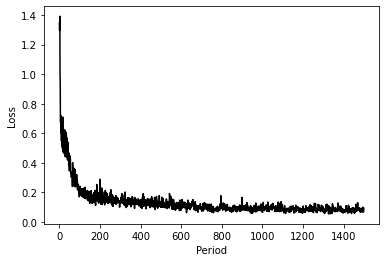

In [7]:
X_df = dataset.loc[:, ['WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B',
        'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2',
       'HWS_S26', 'PUMP_S26', 'MEAN_RAIN']]
y_df = dataset.loc[:, ['WS_S1']]
X = np.array(X_df)
y = np.array(y_df)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)


num_features = X.shape[1]
num_periods = len(X) // 8
X = np.asarray(X).reshape((-1, num_periods, num_features))
y = np.asarray(y).reshape((-1, num_periods))
print("X.shape, y.shape:", X.shape, y.shape)

quantiles = [0.1, 0.5, 1]  # 0.1, 0.5, 1
losses, test_mape, test_mae, test_rmse = train(X, y, quantiles)
#print(test_mape, test_mae, test_rmse)


print('====== MAPE, MAE, RMSE ======')
print(sum(test_mape) / len(test_mape),
      sum(test_mae) / len(test_mae), 
      sum(test_rmse) / len(test_rmse))


plt.plot(range(len(losses)), losses, "k-")
plt.xlabel("Period")
plt.ylabel("Loss")
plt.show()

X.shape, y.shape: (8, 12054, 15) (8, 12054)
(8, 9643, 15) (8, 9643) (8, 2411, 15) (8, 2411)
Epoch 0 start...
Epoch 1 start...
Epoch 2 start...
Epoch 3 start...


Epoch 4 start...
Epoch 5 start...
Epoch 6 start...
Epoch 7 start...


Epoch 8 start...
Epoch 9 start...
Epoch 10 start...
Epoch 11 start...


Epoch 12 start...
Epoch 13 start...
Epoch 14 start...
Epoch 15 start...


Epoch 16 start...
Epoch 17 start...
Epoch 18 start...
Epoch 19 start...


Epoch 20 start...
Epoch 21 start...
Epoch 22 start...
Epoch 23 start...


Epoch 24 start...
Epoch 25 start...
Epoch 26 start...
Epoch 27 start...


Epoch 28 start...
Epoch 29 start...
Epoch 30 start...
Epoch 31 start...


Epoch 32 start...
Epoch 33 start...
Epoch 34 start...
Epoch 35 start...


Epoch 36 start...
Epoch 37 start...
Epoch 38 start...
Epoch 39 start...


Epoch 40 start...
Epoch 41 start...
Epoch 42 start...
Epoch 43 start...


Epoch 44 start...
Epoch 45 start...
Epoch 46 start...
Epoch 47 start...


Epoch 48 start...
Epoch 49 start...
Epoch 50 start...
Epoch 51 start...


Epoch 52 start...
Epoch 53 start...
Epoch 54 start...
Epoch 55 start...


Epoch 56 start...
Epoch 57 start...
Epoch 58 start...
Epoch 59 start...


Epoch 60 start...
Epoch 61 start...
Epoch 62 start...
Epoch 63 start...


Epoch 64 start...
Epoch 65 start...
Epoch 66 start...
Epoch 67 start...


Epoch 68 start...
Epoch 69 start...
Epoch 70 start...
Epoch 71 start...


Epoch 72 start...
Epoch 73 start...
Epoch 74 start...
Epoch 75 start...


Epoch 76 start...
Epoch 77 start...
Epoch 78 start...
Epoch 79 start...


Epoch 80 start...
Epoch 81 start...
Epoch 82 start...
Epoch 83 start...


Epoch 84 start...
Epoch 85 start...
Epoch 86 start...
Epoch 87 start...


Epoch 88 start...
Epoch 89 start...
Epoch 90 start...
Epoch 91 start...


Epoch 92 start...
Epoch 93 start...
Epoch 94 start...
Epoch 95 start...


Epoch 96 start...
Epoch 97 start...
Epoch 98 start...
Epoch 99 start...


Epoch 100 start...
Epoch 101 start...
Epoch 102 start...
Epoch 103 start...


Epoch 104 start...
Epoch 105 start...
Epoch 106 start...
Epoch 107 start...


Epoch 108 start...
Epoch 109 start...
Epoch 110 start...
Epoch 111 start...


Epoch 112 start...
Epoch 113 start...
Epoch 114 start...
Epoch 115 start...


Epoch 116 start...
Epoch 117 start...
Epoch 118 start...
Epoch 119 start...


Epoch 120 start...
Epoch 121 start...
Epoch 122 start...
Epoch 123 start...


Epoch 124 start...
Epoch 125 start...
Epoch 126 start...
Epoch 127 start...


Epoch 128 start...
Epoch 129 start...
Epoch 130 start...
Epoch 131 start...


Epoch 132 start...
Epoch 133 start...
Epoch 134 start...
Epoch 135 start...


Epoch 136 start...
Epoch 137 start...
Epoch 138 start...
Epoch 139 start...


Epoch 140 start...
Epoch 141 start...
Epoch 142 start...
Epoch 143 start...


Epoch 144 start...
Epoch 145 start...
Epoch 146 start...
Epoch 147 start...


Epoch 148 start...
Epoch 149 start...
Epoch 150 start...
Epoch 151 start...


Epoch 152 start...
Epoch 153 start...
Epoch 154 start...
Epoch 155 start...


Epoch 156 start...
Epoch 157 start...
Epoch 158 start...
Epoch 159 start...


Epoch 160 start...
Epoch 161 start...
Epoch 162 start...
Epoch 163 start...


Epoch 164 start...
Epoch 165 start...
Epoch 166 start...
Epoch 167 start...


Epoch 168 start...
Epoch 169 start...
Epoch 170 start...
Epoch 171 start...


Epoch 172 start...
Epoch 173 start...
Epoch 174 start...
Epoch 175 start...


Epoch 176 start...
Epoch 177 start...
Epoch 178 start...
Epoch 179 start...


Epoch 180 start...
Epoch 181 start...
Epoch 182 start...
Epoch 183 start...


Epoch 184 start...
Epoch 185 start...
Epoch 186 start...
Epoch 187 start...


Epoch 188 start...
Epoch 189 start...
Epoch 190 start...
Epoch 191 start...


Epoch 192 start...
Epoch 193 start...
Epoch 194 start...
Epoch 195 start...


Epoch 196 start...
Epoch 197 start...
Epoch 198 start...
Epoch 199 start...


Epoch 200 start...
Epoch 201 start...
Epoch 202 start...
Epoch 203 start...


Epoch 204 start...
Epoch 205 start...
Epoch 206 start...
Epoch 207 start...


Epoch 208 start...
Epoch 209 start...
Epoch 210 start...
Epoch 211 start...


Epoch 212 start...
Epoch 213 start...
Epoch 214 start...
Epoch 215 start...


Epoch 216 start...
Epoch 217 start...
Epoch 218 start...
Epoch 219 start...


Epoch 220 start...
Epoch 221 start...
Epoch 222 start...
Epoch 223 start...


Epoch 224 start...
Epoch 225 start...
Epoch 226 start...
Epoch 227 start...


Epoch 228 start...
Epoch 229 start...
Epoch 230 start...
Epoch 231 start...


Epoch 232 start...
Epoch 233 start...
Epoch 234 start...
Epoch 235 start...


Epoch 236 start...
Epoch 237 start...
Epoch 238 start...
Epoch 239 start...


Epoch 240 start...
Epoch 241 start...
Epoch 242 start...
Epoch 243 start...


Epoch 244 start...
Epoch 245 start...
Epoch 246 start...
Epoch 247 start...


Epoch 248 start...
Epoch 249 start...
Epoch 250 start...
Epoch 251 start...


Epoch 252 start...
Epoch 253 start...
Epoch 254 start...
Epoch 255 start...


Epoch 256 start...
Epoch 257 start...
Epoch 258 start...
Epoch 259 start...


Epoch 260 start...
Epoch 261 start...
Epoch 262 start...
Epoch 263 start...


Epoch 264 start...
Epoch 265 start...
Epoch 266 start...
Epoch 267 start...


Epoch 268 start...
Epoch 269 start...
Epoch 270 start...
Epoch 271 start...


Epoch 272 start...
Epoch 273 start...
Epoch 274 start...
Epoch 275 start...


Epoch 276 start...
Epoch 277 start...
Epoch 278 start...
Epoch 279 start...


Epoch 280 start...
Epoch 281 start...
Epoch 282 start...
Epoch 283 start...


Epoch 284 start...
Epoch 285 start...
Epoch 286 start...
Epoch 287 start...


Epoch 288 start...
Epoch 289 start...
Epoch 290 start...
Epoch 291 start...


Epoch 292 start...
Epoch 293 start...
Epoch 294 start...
Epoch 295 start...


Epoch 296 start...
Epoch 297 start...
Epoch 298 start...
Epoch 299 start...


Epoch 300 start...
Epoch 301 start...
Epoch 302 start...
Epoch 303 start...


Epoch 304 start...
Epoch 305 start...
Epoch 306 start...
Epoch 307 start...


Epoch 308 start...
Epoch 309 start...
Epoch 310 start...
Epoch 311 start...


Epoch 312 start...
Epoch 313 start...
Epoch 314 start...
Epoch 315 start...


Epoch 316 start...
Epoch 317 start...
Epoch 318 start...
Epoch 319 start...


Epoch 320 start...
Epoch 321 start...
Epoch 322 start...
Epoch 323 start...


Epoch 324 start...
Epoch 325 start...
Epoch 326 start...
Epoch 327 start...


Epoch 328 start...
Epoch 329 start...
Epoch 330 start...
Epoch 331 start...


Epoch 332 start...
Epoch 333 start...
Epoch 334 start...
Epoch 335 start...


Epoch 336 start...
Epoch 337 start...
Epoch 338 start...
Epoch 339 start...


Epoch 340 start...
Epoch 341 start...
Epoch 342 start...
Epoch 343 start...


Epoch 344 start...
Epoch 345 start...
Epoch 346 start...
Epoch 347 start...


Epoch 348 start...
Epoch 349 start...
Epoch 350 start...
Epoch 351 start...


Epoch 352 start...
Epoch 353 start...
Epoch 354 start...
Epoch 355 start...


Epoch 356 start...
Epoch 357 start...
Epoch 358 start...
Epoch 359 start...


Epoch 360 start...
Epoch 361 start...
Epoch 362 start...
Epoch 363 start...


Epoch 364 start...
Epoch 365 start...
Epoch 366 start...
Epoch 367 start...


Epoch 368 start...
Epoch 369 start...
Epoch 370 start...
Epoch 371 start...


Epoch 372 start...
Epoch 373 start...
Epoch 374 start...
Epoch 375 start...


Epoch 376 start...
Epoch 377 start...
Epoch 378 start...
Epoch 379 start...


Epoch 380 start...
Epoch 381 start...
Epoch 382 start...
Epoch 383 start...


Epoch 384 start...
Epoch 385 start...
Epoch 386 start...
Epoch 387 start...


Epoch 388 start...
Epoch 389 start...
Epoch 390 start...
Epoch 391 start...


Epoch 392 start...
Epoch 393 start...
Epoch 394 start...
Epoch 395 start...


Epoch 396 start...
Epoch 397 start...
Epoch 398 start...
Epoch 399 start...


Epoch 400 start...
Epoch 401 start...
Epoch 402 start...
Epoch 403 start...


Epoch 404 start...
Epoch 405 start...
Epoch 406 start...
Epoch 407 start...


Epoch 408 start...
Epoch 409 start...
Epoch 410 start...
Epoch 411 start...


Epoch 412 start...
Epoch 413 start...
Epoch 414 start...
Epoch 415 start...


Epoch 416 start...
Epoch 417 start...
Epoch 418 start...
Epoch 419 start...


Epoch 420 start...
Epoch 421 start...
Epoch 422 start...
Epoch 423 start...


Epoch 424 start...
Epoch 425 start...
Epoch 426 start...
Epoch 427 start...


Epoch 428 start...
Epoch 429 start...
Epoch 430 start...
Epoch 431 start...


Epoch 432 start...
Epoch 433 start...
Epoch 434 start...
Epoch 435 start...


Epoch 436 start...
Epoch 437 start...
Epoch 438 start...
Epoch 439 start...


Epoch 440 start...
Epoch 441 start...
Epoch 442 start...
Epoch 443 start...


Epoch 444 start...
Epoch 445 start...
Epoch 446 start...
Epoch 447 start...


Epoch 448 start...
Epoch 449 start...
Epoch 450 start...
Epoch 451 start...


Epoch 452 start...
Epoch 453 start...
Epoch 454 start...
Epoch 455 start...


Epoch 456 start...
Epoch 457 start...
Epoch 458 start...
Epoch 459 start...


Epoch 460 start...
Epoch 461 start...
Epoch 462 start...
Epoch 463 start...


Epoch 464 start...
Epoch 465 start...
Epoch 466 start...
Epoch 467 start...


Epoch 468 start...
Epoch 469 start...
Epoch 470 start...
Epoch 471 start...


Epoch 472 start...
Epoch 473 start...
Epoch 474 start...
Epoch 475 start...


Epoch 476 start...
Epoch 477 start...
Epoch 478 start...
Epoch 479 start...


Epoch 480 start...
Epoch 481 start...
Epoch 482 start...
Epoch 483 start...


Epoch 484 start...
Epoch 485 start...
Epoch 486 start...
Epoch 487 start...


Epoch 488 start...
Epoch 489 start...
Epoch 490 start...
Epoch 491 start...


Epoch 492 start...
Epoch 493 start...
Epoch 494 start...
Epoch 495 start...


Epoch 496 start...
Epoch 497 start...
Epoch 498 start...
Epoch 499 start...


100% |######################################################################################################################################################|


Prediction: 0
Prediction: 1
Prediction: 2
Prediction: 3
Prediction: 4
Prediction: 5
Prediction: 6
Prediction: 7
Prediction: 8
Prediction: 9
Prediction: 10
Prediction: 11
Prediction: 12
Prediction: 13
Prediction: 14
Prediction: 15
Prediction: 16
Prediction: 17
Prediction: 18
Prediction: 19
Prediction: 20
Prediction: 21
Prediction: 22
Prediction: 23
Prediction: 24
Prediction: 25
Prediction: 26
Prediction: 27
Prediction: 28
Prediction: 29
Prediction: 30
Prediction: 31
Prediction: 32
Prediction: 33
Prediction: 34
Prediction: 35
Prediction: 36


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 37
Prediction: 38


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 39
Prediction: 40


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 41
Prediction: 42
Prediction: 43


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 44
Prediction: 45
Prediction: 46
Prediction: 47
Prediction: 48
Prediction: 49
Prediction: 50
Prediction: 51
Prediction: 52
Prediction: 53
Prediction: 54
Prediction: 55
Prediction: 56
Prediction: 57
Prediction: 58
Prediction: 59
Prediction: 60
Prediction: 61
Prediction: 62
Prediction: 63
Prediction: 64
Prediction: 65
Prediction: 66
Prediction: 67
Prediction: 68
Prediction: 69
Prediction: 70
Prediction: 71
Prediction: 72
Prediction: 73
Prediction: 74
Prediction: 75
Prediction: 76
Prediction: 77
Prediction: 78
Prediction: 79
Prediction: 80
Prediction: 81
Prediction: 82
Prediction: 83
Prediction: 84
Prediction: 85
Prediction: 86
Prediction: 87
Prediction: 88
Prediction: 89
Prediction: 90
Prediction: 91
Prediction: 92
Prediction: 93
Prediction: 94
Prediction: 95
Prediction: 96
Prediction: 97
Prediction: 98
Prediction: 99
Prediction: 100
Prediction: 101
Prediction: 102
Prediction: 103
Prediction: 104
Prediction: 105
Prediction: 106
Prediction: 107
Prediction: 108


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 109
Prediction: 110


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 111
Prediction: 112
Prediction: 113


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 114
Prediction: 115


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 116
Prediction: 117
Prediction: 118


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 119
Prediction: 120
Prediction: 121
Prediction: 122
Prediction: 123
Prediction: 124
Prediction: 125
Prediction: 126
Prediction: 127
Prediction: 128
Prediction: 129
Prediction: 130
Prediction: 131
Prediction: 132
Prediction: 133
Prediction: 134
Prediction: 135
Prediction: 136
Prediction: 137
Prediction: 138
Prediction: 139


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 140


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 141
Prediction: 142


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 143
Prediction: 144


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 145


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 146
Prediction: 147
Prediction: 148


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 149
Prediction: 150


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 151
Prediction: 152
Prediction: 153
Prediction: 154
Prediction: 155
Prediction: 156
Prediction: 157
Prediction: 158
Prediction: 159
Prediction: 160
Prediction: 161
Prediction: 162
Prediction: 163
Prediction: 164
Prediction: 165
Prediction: 166
Prediction: 167
Prediction: 168
Prediction: 169
Prediction: 170
Prediction: 171
Prediction: 172
Prediction: 173
Prediction: 174
Prediction: 175
Prediction: 176
Prediction: 177
Prediction: 178
Prediction: 179
Prediction: 180
Prediction: 181
Prediction: 182
Prediction: 183
Prediction: 184
Prediction: 185
Prediction: 186
Prediction: 187
Prediction: 188
Prediction: 189
Prediction: 190
Prediction: 191


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 192
Prediction: 193
Prediction: 194
Prediction: 195


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 196


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 197


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 198
Prediction: 199


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 200
Prediction: 201
Prediction: 202


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 203


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 204
Prediction: 205
Prediction: 206


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 207
Prediction: 208
Prediction: 209
Prediction: 210
Prediction: 211
Prediction: 212
Prediction: 213
Prediction: 214
Prediction: 215
Prediction: 216
Prediction: 217
Prediction: 218
Prediction: 219
Prediction: 220
Prediction: 221
Prediction: 222
Prediction: 223
Prediction: 224
Prediction: 225
Prediction: 226
Prediction: 227
Prediction: 228
Prediction: 229
Prediction: 230
Prediction: 231
Prediction: 232
Prediction: 233
Prediction: 234
Prediction: 235
Prediction: 236
Prediction: 237
Prediction: 238
Prediction: 239
Prediction: 240
Prediction: 241
Prediction: 242
Prediction: 243
Prediction: 244
Prediction: 245
Prediction: 246
Prediction: 247
Prediction: 248
Prediction: 249
Prediction: 250
Prediction: 251
Prediction: 252
Prediction: 253
Prediction: 254


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 255
Prediction: 256
Prediction: 257


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 258
Prediction: 259
Prediction: 260


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 261


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 262


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 263
Prediction: 264


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 265
Prediction: 266
Prediction: 267
Prediction: 268
Prediction: 269
Prediction: 270
Prediction: 271
Prediction: 272
Prediction: 273
Prediction: 274
Prediction: 275
Prediction: 276
Prediction: 277
Prediction: 278
Prediction: 279
Prediction: 280
Prediction: 281
Prediction: 282
Prediction: 283
Prediction: 284
Prediction: 285
Prediction: 286
Prediction: 287
Prediction: 288
Prediction: 289
Prediction: 290
Prediction: 291
Prediction: 292
Prediction: 293
Prediction: 294
Prediction: 295
Prediction: 296
Prediction: 297
Prediction: 298
Prediction: 299
Prediction: 300
Prediction: 301
Prediction: 302
Prediction: 303
Prediction: 304
Prediction: 305
Prediction: 306
Prediction: 307
Prediction: 308
Prediction: 309
Prediction: 310
Prediction: 311
Prediction: 312
Prediction: 313
Prediction: 314
Prediction: 315
Prediction: 316


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 317
Prediction: 318
Prediction: 319


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 320
Prediction: 321
Prediction: 322
Prediction: 323
Prediction: 324
Prediction: 325


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 326
Prediction: 327
Prediction: 328
Prediction: 329


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 330
Prediction: 331
Prediction: 332
Prediction: 333
Prediction: 334
Prediction: 335
Prediction: 336
Prediction: 337
Prediction: 338
Prediction: 339
Prediction: 340
Prediction: 341
Prediction: 342
Prediction: 343
Prediction: 344
Prediction: 345
Prediction: 346
Prediction: 347
Prediction: 348
Prediction: 349
Prediction: 350
Prediction: 351
Prediction: 352
Prediction: 353
Prediction: 354
Prediction: 355
Prediction: 356
Prediction: 357
Prediction: 358
Prediction: 359
Prediction: 360
Prediction: 361
Prediction: 362
Prediction: 363
Prediction: 364
Prediction: 365
Prediction: 366
Prediction: 367
Prediction: 368
Prediction: 369
Prediction: 370
Prediction: 371
Prediction: 372
Prediction: 373
Prediction: 374
Prediction: 375
Prediction: 376
Prediction: 377
Prediction: 378
Prediction: 379
Prediction: 380
Prediction: 381
Prediction: 382
Prediction: 383
Prediction: 384
Prediction: 385
Prediction: 386
Prediction: 387
Prediction: 388
Prediction: 389
Prediction: 390
Prediction: 391
Predicti

/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 559
Prediction: 560


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 561
Prediction: 562
Prediction: 563


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 564


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 565
Prediction: 566


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 567
Prediction: 568


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 569
Prediction: 570
Prediction: 571
Prediction: 572
Prediction: 573
Prediction: 574
Prediction: 575
Prediction: 576
Prediction: 577
Prediction: 578
Prediction: 579
Prediction: 580
Prediction: 581
Prediction: 582
Prediction: 583
Prediction: 584
Prediction: 585
Prediction: 586
Prediction: 587
Prediction: 588
Prediction: 589
Prediction: 590
Prediction: 591
Prediction: 592
Prediction: 593
Prediction: 594
Prediction: 595
Prediction: 596
Prediction: 597
Prediction: 598
Prediction: 599
Prediction: 600


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 601
Prediction: 602


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 603
Prediction: 604


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 605


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 606
Prediction: 607


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 608
Prediction: 609
Prediction: 610


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 611
Prediction: 612
Prediction: 613
Prediction: 614
Prediction: 615
Prediction: 616
Prediction: 617


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 618
Prediction: 619


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 620


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 621
Prediction: 622
Prediction: 623


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 624
Prediction: 625


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 626


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 627
Prediction: 628


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 629
Prediction: 630
Prediction: 631
Prediction: 632
Prediction: 633
Prediction: 634
Prediction: 635
Prediction: 636
Prediction: 637
Prediction: 638
Prediction: 639
Prediction: 640
Prediction: 641
Prediction: 642
Prediction: 643
Prediction: 644
Prediction: 645
Prediction: 646
Prediction: 647
Prediction: 648
Prediction: 649
Prediction: 650
Prediction: 651
Prediction: 652
Prediction: 653
Prediction: 654
Prediction: 655
Prediction: 656
Prediction: 657
Prediction: 658
Prediction: 659
Prediction: 660
Prediction: 661
Prediction: 662


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 663
Prediction: 664


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 665
Prediction: 666


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 667


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 668


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 669
Prediction: 670
Prediction: 671


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 672
Prediction: 673
Prediction: 674
Prediction: 675
Prediction: 676
Prediction: 677
Prediction: 678
Prediction: 679
Prediction: 680
Prediction: 681
Prediction: 682
Prediction: 683
Prediction: 684
Prediction: 685
Prediction: 686
Prediction: 687
Prediction: 688
Prediction: 689
Prediction: 690
Prediction: 691
Prediction: 692
Prediction: 693
Prediction: 694
Prediction: 695
Prediction: 696
Prediction: 697
Prediction: 698
Prediction: 699
Prediction: 700
Prediction: 701
Prediction: 702
Prediction: 703
Prediction: 704
Prediction: 705
Prediction: 706
Prediction: 707
Prediction: 708
Prediction: 709
Prediction: 710
Prediction: 711
Prediction: 712
Prediction: 713
Prediction: 714
Prediction: 715
Prediction: 716
Prediction: 717
Prediction: 718
Prediction: 719
Prediction: 720
Prediction: 721
Prediction: 722
Prediction: 723
Prediction: 724
Prediction: 725
Prediction: 726
Prediction: 727
Prediction: 728
Prediction: 729
Prediction: 730
Prediction: 731
Prediction: 732
Prediction: 733
Predicti

/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 748
Prediction: 749


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 750
Prediction: 751


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 752


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 753


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 754
Prediction: 755
Prediction: 756


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 757
Prediction: 758


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 759
Prediction: 760
Prediction: 761
Prediction: 762
Prediction: 763
Prediction: 764
Prediction: 765
Prediction: 766
Prediction: 767
Prediction: 768
Prediction: 769
Prediction: 770
Prediction: 771
Prediction: 772
Prediction: 773
Prediction: 774
Prediction: 775
Prediction: 776
Prediction: 777
Prediction: 778
Prediction: 779
Prediction: 780
Prediction: 781
Prediction: 782
Prediction: 783
Prediction: 784
Prediction: 785
Prediction: 786
Prediction: 787
Prediction: 788
Prediction: 789
Prediction: 790
Prediction: 791
Prediction: 792
Prediction: 793
Prediction: 794
Prediction: 795
Prediction: 796
Prediction: 797
Prediction: 798
Prediction: 799
Prediction: 800
Prediction: 801
Prediction: 802
Prediction: 803
Prediction: 804
Prediction: 805
Prediction: 806
Prediction: 807
Prediction: 808
Prediction: 809
Prediction: 810
Prediction: 811
Prediction: 812
Prediction: 813
Prediction: 814
Prediction: 815
Prediction: 816
Prediction: 817
Prediction: 818


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 819


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 820


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 821
Prediction: 822
Prediction: 823


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 824
Prediction: 825
Prediction: 826
Prediction: 827


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 828
Prediction: 829
Prediction: 830
Prediction: 831
Prediction: 832
Prediction: 833
Prediction: 834
Prediction: 835
Prediction: 836
Prediction: 837
Prediction: 838
Prediction: 839
Prediction: 840
Prediction: 841
Prediction: 842
Prediction: 843
Prediction: 844
Prediction: 845
Prediction: 846
Prediction: 847
Prediction: 848
Prediction: 849
Prediction: 850
Prediction: 851
Prediction: 852
Prediction: 853
Prediction: 854
Prediction: 855
Prediction: 856
Prediction: 857
Prediction: 858
Prediction: 859
Prediction: 860
Prediction: 861
Prediction: 862
Prediction: 863
Prediction: 864
Prediction: 865
Prediction: 866
Prediction: 867
Prediction: 868
Prediction: 869
Prediction: 870
Prediction: 871
Prediction: 872
Prediction: 873
Prediction: 874
Prediction: 875
Prediction: 876
Prediction: 877
Prediction: 878
Prediction: 879
Prediction: 880
Prediction: 881
Prediction: 882
Prediction: 883
Prediction: 884
Prediction: 885
Prediction: 886
Prediction: 887
Prediction: 888
Prediction: 889
Predicti

/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 942


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 943
Prediction: 944
Prediction: 945


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 946
Prediction: 947


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 948
Prediction: 949


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 950
Prediction: 951


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 952
Prediction: 953
Prediction: 954
Prediction: 955
Prediction: 956
Prediction: 957
Prediction: 958
Prediction: 959
Prediction: 960
Prediction: 961
Prediction: 962
Prediction: 963
Prediction: 964
Prediction: 965
Prediction: 966
Prediction: 967
Prediction: 968
Prediction: 969
Prediction: 970
Prediction: 971
Prediction: 972
Prediction: 973
Prediction: 974
Prediction: 975
Prediction: 976
Prediction: 977
Prediction: 978
Prediction: 979
Prediction: 980
Prediction: 981
Prediction: 982
Prediction: 983
Prediction: 984
Prediction: 985
Prediction: 986
Prediction: 987
Prediction: 988
Prediction: 989
Prediction: 990
Prediction: 991
Prediction: 992
Prediction: 993
Prediction: 994
Prediction: 995
Prediction: 996
Prediction: 997
Prediction: 998
Prediction: 999
Prediction: 1000
Prediction: 1001
Prediction: 1002
Prediction: 1003
Prediction: 1004
Prediction: 1005
Prediction: 1006
Prediction: 1007
Prediction: 1008
Prediction: 1009
Prediction: 1010
Prediction: 1011
Prediction: 1012
Prediction:

/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1207
Prediction: 1208


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1209
Prediction: 1210


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1211
Prediction: 1212


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1213
Prediction: 1214
Prediction: 1215
Prediction: 1216


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1217
Prediction: 1218
Prediction: 1219
Prediction: 1220
Prediction: 1221
Prediction: 1222
Prediction: 1223
Prediction: 1224
Prediction: 1225
Prediction: 1226
Prediction: 1227
Prediction: 1228
Prediction: 1229
Prediction: 1230
Prediction: 1231
Prediction: 1232
Prediction: 1233
Prediction: 1234
Prediction: 1235
Prediction: 1236
Prediction: 1237
Prediction: 1238
Prediction: 1239
Prediction: 1240
Prediction: 1241
Prediction: 1242
Prediction: 1243
Prediction: 1244
Prediction: 1245
Prediction: 1246
Prediction: 1247
Prediction: 1248
Prediction: 1249
Prediction: 1250


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1251
Prediction: 1252


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1253
Prediction: 1254


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1255
Prediction: 1256


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1257
Prediction: 1258
Prediction: 1259


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1260
Prediction: 1261
Prediction: 1262
Prediction: 1263
Prediction: 1264
Prediction: 1265
Prediction: 1266
Prediction: 1267
Prediction: 1268
Prediction: 1269
Prediction: 1270
Prediction: 1271
Prediction: 1272
Prediction: 1273
Prediction: 1274
Prediction: 1275
Prediction: 1276
Prediction: 1277
Prediction: 1278
Prediction: 1279
Prediction: 1280
Prediction: 1281
Prediction: 1282
Prediction: 1283
Prediction: 1284
Prediction: 1285
Prediction: 1286
Prediction: 1287
Prediction: 1288
Prediction: 1289
Prediction: 1290
Prediction: 1291
Prediction: 1292
Prediction: 1293
Prediction: 1294
Prediction: 1295
Prediction: 1296
Prediction: 1297
Prediction: 1298
Prediction: 1299
Prediction: 1300
Prediction: 1301
Prediction: 1302
Prediction: 1303
Prediction: 1304
Prediction: 1305
Prediction: 1306
Prediction: 1307
Prediction: 1308
Prediction: 1309
Prediction: 1310
Prediction: 1311
Prediction: 1312
Prediction: 1313
Prediction: 1314
Prediction: 1315
Prediction: 1316
Prediction: 1317
Prediction: 13

/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1331
Prediction: 1332


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1333
Prediction: 1334
Prediction: 1335


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1336


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1337
Prediction: 1338
Prediction: 1339
Prediction: 1340
Prediction: 1341
Prediction: 1342
Prediction: 1343
Prediction: 1344
Prediction: 1345
Prediction: 1346
Prediction: 1347
Prediction: 1348
Prediction: 1349
Prediction: 1350
Prediction: 1351
Prediction: 1352


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1353
Prediction: 1354
Prediction: 1355
Prediction: 1356


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1357
Prediction: 1358
Prediction: 1359
Prediction: 1360
Prediction: 1361


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1362
Prediction: 1363
Prediction: 1364
Prediction: 1365
Prediction: 1366
Prediction: 1367
Prediction: 1368
Prediction: 1369
Prediction: 1370
Prediction: 1371
Prediction: 1372
Prediction: 1373
Prediction: 1374
Prediction: 1375
Prediction: 1376
Prediction: 1377
Prediction: 1378
Prediction: 1379
Prediction: 1380
Prediction: 1381
Prediction: 1382
Prediction: 1383
Prediction: 1384
Prediction: 1385
Prediction: 1386
Prediction: 1387
Prediction: 1388
Prediction: 1389


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1390


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1391
Prediction: 1392


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1393
Prediction: 1394


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1395
Prediction: 1396


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1397
Prediction: 1398
Prediction: 1399


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1400
Prediction: 1401
Prediction: 1402
Prediction: 1403
Prediction: 1404
Prediction: 1405
Prediction: 1406
Prediction: 1407
Prediction: 1408
Prediction: 1409
Prediction: 1410
Prediction: 1411
Prediction: 1412
Prediction: 1413
Prediction: 1414
Prediction: 1415
Prediction: 1416
Prediction: 1417
Prediction: 1418
Prediction: 1419
Prediction: 1420
Prediction: 1421
Prediction: 1422
Prediction: 1423
Prediction: 1424
Prediction: 1425
Prediction: 1426
Prediction: 1427
Prediction: 1428
Prediction: 1429
Prediction: 1430
Prediction: 1431
Prediction: 1432
Prediction: 1433
Prediction: 1434
Prediction: 1435
Prediction: 1436
Prediction: 1437
Prediction: 1438
Prediction: 1439
Prediction: 1440
Prediction: 1441
Prediction: 1442
Prediction: 1443
Prediction: 1444
Prediction: 1445
Prediction: 1446
Prediction: 1447
Prediction: 1448
Prediction: 1449
Prediction: 1450
Prediction: 1451
Prediction: 1452
Prediction: 1453
Prediction: 1454
Prediction: 1455
Prediction: 1456
Prediction: 1457
Prediction: 14

/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1499
Prediction: 1500


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1501
Prediction: 1502


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1503
Prediction: 1504


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1505
Prediction: 1506
Prediction: 1507
Prediction: 1508
Prediction: 1509
Prediction: 1510
Prediction: 1511
Prediction: 1512
Prediction: 1513
Prediction: 1514
Prediction: 1515
Prediction: 1516
Prediction: 1517
Prediction: 1518
Prediction: 1519
Prediction: 1520
Prediction: 1521
Prediction: 1522
Prediction: 1523
Prediction: 1524
Prediction: 1525
Prediction: 1526
Prediction: 1527
Prediction: 1528
Prediction: 1529
Prediction: 1530
Prediction: 1531
Prediction: 1532


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1533
Prediction: 1534
Prediction: 1535


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1536


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1537
Prediction: 1538
Prediction: 1539


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1540


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1541
Prediction: 1542


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1543
Prediction: 1544
Prediction: 1545
Prediction: 1546
Prediction: 1547
Prediction: 1548
Prediction: 1549
Prediction: 1550
Prediction: 1551
Prediction: 1552
Prediction: 1553
Prediction: 1554
Prediction: 1555
Prediction: 1556
Prediction: 1557
Prediction: 1558
Prediction: 1559
Prediction: 1560
Prediction: 1561
Prediction: 1562
Prediction: 1563
Prediction: 1564
Prediction: 1565
Prediction: 1566
Prediction: 1567
Prediction: 1568
Prediction: 1569
Prediction: 1570
Prediction: 1571
Prediction: 1572
Prediction: 1573
Prediction: 1574
Prediction: 1575
Prediction: 1576
Prediction: 1577
Prediction: 1578
Prediction: 1579
Prediction: 1580
Prediction: 1581
Prediction: 1582
Prediction: 1583
Prediction: 1584
Prediction: 1585
Prediction: 1586
Prediction: 1587
Prediction: 1588
Prediction: 1589
Prediction: 1590
Prediction: 1591
Prediction: 1592
Prediction: 1593
Prediction: 1594
Prediction: 1595
Prediction: 1596
Prediction: 1597
Prediction: 1598
Prediction: 1599
Prediction: 1600
Prediction: 16

/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1632
Prediction: 1633


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1634


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1635
Prediction: 1636
Prediction: 1637


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1638


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1639
Prediction: 1640


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1641
Prediction: 1642


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1643
Prediction: 1644
Prediction: 1645
Prediction: 1646
Prediction: 1647
Prediction: 1648
Prediction: 1649
Prediction: 1650
Prediction: 1651
Prediction: 1652
Prediction: 1653
Prediction: 1654
Prediction: 1655
Prediction: 1656
Prediction: 1657
Prediction: 1658
Prediction: 1659
Prediction: 1660
Prediction: 1661
Prediction: 1662
Prediction: 1663
Prediction: 1664
Prediction: 1665
Prediction: 1666
Prediction: 1667
Prediction: 1668
Prediction: 1669
Prediction: 1670
Prediction: 1671
Prediction: 1672
Prediction: 1673
Prediction: 1674
Prediction: 1675
Prediction: 1676
Prediction: 1677
Prediction: 1678
Prediction: 1679
Prediction: 1680
Prediction: 1681
Prediction: 1682
Prediction: 1683
Prediction: 1684
Prediction: 1685
Prediction: 1686
Prediction: 1687
Prediction: 1688
Prediction: 1689
Prediction: 1690
Prediction: 1691
Prediction: 1692
Prediction: 1693
Prediction: 1694
Prediction: 1695
Prediction: 1696
Prediction: 1697
Prediction: 1698
Prediction: 1699
Prediction: 1700
Prediction: 17

/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1834
Prediction: 1835


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1836
Prediction: 1837


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1838
Prediction: 1839


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1840


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1841
Prediction: 1842
Prediction: 1843


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1844
Prediction: 1845
Prediction: 1846


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1847
Prediction: 1848


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1849
Prediction: 1850
Prediction: 1851


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1852
Prediction: 1853


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1854


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1855
Prediction: 1856
Prediction: 1857
Prediction: 1858
Prediction: 1859
Prediction: 1860
Prediction: 1861
Prediction: 1862
Prediction: 1863
Prediction: 1864
Prediction: 1865
Prediction: 1866
Prediction: 1867
Prediction: 1868
Prediction: 1869
Prediction: 1870
Prediction: 1871
Prediction: 1872
Prediction: 1873
Prediction: 1874
Prediction: 1875
Prediction: 1876
Prediction: 1877
Prediction: 1878
Prediction: 1879
Prediction: 1880
Prediction: 1881
Prediction: 1882
Prediction: 1883
Prediction: 1884
Prediction: 1885
Prediction: 1886
Prediction: 1887
Prediction: 1888
Prediction: 1889
Prediction: 1890
Prediction: 1891
Prediction: 1892
Prediction: 1893
Prediction: 1894
Prediction: 1895
Prediction: 1896
Prediction: 1897
Prediction: 1898
Prediction: 1899
Prediction: 1900
Prediction: 1901
Prediction: 1902
Prediction: 1903
Prediction: 1904
Prediction: 1905
Prediction: 1906
Prediction: 1907
Prediction: 1908
Prediction: 1909
Prediction: 1910
Prediction: 1911
Prediction: 1912
Prediction: 19

/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1975


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1976
Prediction: 1977


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1978
Prediction: 1979
Prediction: 1980


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1981
Prediction: 1982
Prediction: 1983
Prediction: 1984


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1985
Prediction: 1986
Prediction: 1987
Prediction: 1988
Prediction: 1989
Prediction: 1990
Prediction: 1991
Prediction: 1992
Prediction: 1993
Prediction: 1994
Prediction: 1995


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1996
Prediction: 1997


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1998
Prediction: 1999
Prediction: 2000


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2001
Prediction: 2002


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2003
Prediction: 2004
Prediction: 2005


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2006
Prediction: 2007


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2008
Prediction: 2009


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2010
Prediction: 2011


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2012
Prediction: 2013


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2014
Prediction: 2015
Prediction: 2016
Prediction: 2017
Prediction: 2018
Prediction: 2019
Prediction: 2020
Prediction: 2021
Prediction: 2022
Prediction: 2023
Prediction: 2024
Prediction: 2025
Prediction: 2026
Prediction: 2027
Prediction: 2028
Prediction: 2029
Prediction: 2030
Prediction: 2031
Prediction: 2032
Prediction: 2033
Prediction: 2034
Prediction: 2035
Prediction: 2036
Prediction: 2037
Prediction: 2038
Prediction: 2039
Prediction: 2040
Prediction: 2041
Prediction: 2042
Prediction: 2043
Prediction: 2044
Prediction: 2045
Prediction: 2046
Prediction: 2047
Prediction: 2048
Prediction: 2049
Prediction: 2050
Prediction: 2051
Prediction: 2052
Prediction: 2053
Prediction: 2054
Prediction: 2055
Prediction: 2056
Prediction: 2057
Prediction: 2058
Prediction: 2059
Prediction: 2060
Prediction: 2061
Prediction: 2062
Prediction: 2063
Prediction: 2064
Prediction: 2065
Prediction: 2066
Prediction: 2067
Prediction: 2068
Prediction: 2069
Prediction: 2070
Prediction: 2071
Prediction: 20

/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2122
Prediction: 2123
Prediction: 2124


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2125
Prediction: 2126


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2127
Prediction: 2128


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2129
Prediction: 2130
Prediction: 2131
Prediction: 2132
Prediction: 2133
Prediction: 2134
Prediction: 2135
Prediction: 2136
Prediction: 2137
Prediction: 2138
Prediction: 2139
Prediction: 2140
Prediction: 2141
Prediction: 2142
Prediction: 2143
Prediction: 2144
Prediction: 2145
Prediction: 2146
Prediction: 2147
Prediction: 2148
Prediction: 2149
Prediction: 2150
Prediction: 2151
Prediction: 2152
Prediction: 2153
Prediction: 2154
Prediction: 2155
Prediction: 2156
Prediction: 2157
Prediction: 2158
Prediction: 2159
Prediction: 2160
Prediction: 2161
Prediction: 2162
Prediction: 2163
Prediction: 2164
Prediction: 2165
Prediction: 2166


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2167


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2168


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2169
Prediction: 2170
Prediction: 2171


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2172


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2173
Prediction: 2174


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2175
Prediction: 2176
Prediction: 2177
Prediction: 2178
Prediction: 2179
Prediction: 2180
Prediction: 2181
Prediction: 2182
Prediction: 2183
Prediction: 2184
Prediction: 2185
Prediction: 2186
Prediction: 2187
Prediction: 2188
Prediction: 2189
Prediction: 2190
Prediction: 2191
Prediction: 2192
Prediction: 2193
Prediction: 2194
Prediction: 2195
Prediction: 2196
Prediction: 2197
Prediction: 2198
Prediction: 2199
Prediction: 2200
Prediction: 2201
Prediction: 2202
Prediction: 2203
Prediction: 2204
Prediction: 2205
Prediction: 2206
Prediction: 2207
Prediction: 2208
Prediction: 2209
Prediction: 2210
Prediction: 2211
Prediction: 2212
Prediction: 2213
Prediction: 2214
Prediction: 2215
Prediction: 2216
Prediction: 2217
Prediction: 2218
Prediction: 2219
Prediction: 2220
Prediction: 2221
Prediction: 2222
Prediction: 2223
Prediction: 2224
Prediction: 2225
Prediction: 2226
Prediction: 2227
Prediction: 2228
Prediction: 2229
Prediction: 2230
Prediction: 2231
Prediction: 2232
Prediction: 22

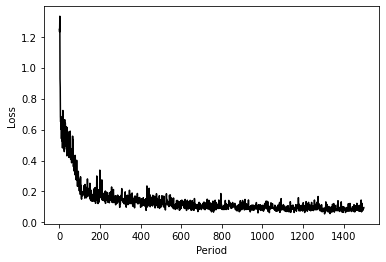

In [8]:
X_df = dataset.loc[:, ['WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2',
       'HWS_S26', 'PUMP_S26', 'MEAN_RAIN']]
y_df = dataset.loc[:, ['TWS_S25A']]
X = np.array(X_df)
y = np.array(y_df)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)


num_features = X.shape[1]
num_periods = len(X) // 8
X = np.asarray(X).reshape((-1, num_periods, num_features))
y = np.asarray(y).reshape((-1, num_periods))
print("X.shape, y.shape:", X.shape, y.shape)

quantiles = [0.1, 0.5, 1]  # 0.1, 0.5, 1
losses, test_mape, test_mae, test_rmse = train(X, y, quantiles)
#print(test_mape, test_mae, test_rmse)


print('====== MAPE, MAE, RMSE ======')
print(sum(test_mape) / len(test_mape),
      sum(test_mae) / len(test_mae), 
      sum(test_rmse) / len(test_rmse))


plt.plot(range(len(losses)), losses, "k-")
plt.xlabel("Period")
plt.ylabel("Loss")
plt.show()

X.shape, y.shape: (8, 12054, 15) (8, 12054)
(8, 9643, 15) (8, 9643) (8, 2411, 15) (8, 2411)
Epoch 0 start...
Epoch 1 start...
Epoch 2 start...
Epoch 3 start...


Epoch 4 start...
Epoch 5 start...
Epoch 6 start...
Epoch 7 start...


Epoch 8 start...
Epoch 9 start...
Epoch 10 start...
Epoch 11 start...


Epoch 12 start...
Epoch 13 start...
Epoch 14 start...
Epoch 15 start...


Epoch 16 start...
Epoch 17 start...
Epoch 18 start...
Epoch 19 start...


Epoch 20 start...
Epoch 21 start...
Epoch 22 start...
Epoch 23 start...


Epoch 24 start...
Epoch 25 start...
Epoch 26 start...
Epoch 27 start...


Epoch 28 start...
Epoch 29 start...
Epoch 30 start...
Epoch 31 start...


Epoch 32 start...
Epoch 33 start...
Epoch 34 start...
Epoch 35 start...


Epoch 36 start...
Epoch 37 start...
Epoch 38 start...
Epoch 39 start...


Epoch 40 start...
Epoch 41 start...
Epoch 42 start...
Epoch 43 start...


Epoch 44 start...
Epoch 45 start...
Epoch 46 start...
Epoch 47 start...


Epoch 48 start...
Epoch 49 start...
Epoch 50 start...
Epoch 51 start...


Epoch 52 start...
Epoch 53 start...
Epoch 54 start...
Epoch 55 start...


Epoch 56 start...
Epoch 57 start...
Epoch 58 start...
Epoch 59 start...


Epoch 60 start...
Epoch 61 start...
Epoch 62 start...
Epoch 63 start...


Epoch 64 start...
Epoch 65 start...
Epoch 66 start...
Epoch 67 start...


Epoch 68 start...
Epoch 69 start...
Epoch 70 start...
Epoch 71 start...


Epoch 72 start...
Epoch 73 start...
Epoch 74 start...
Epoch 75 start...


Epoch 76 start...
Epoch 77 start...
Epoch 78 start...
Epoch 79 start...


Epoch 80 start...
Epoch 81 start...
Epoch 82 start...
Epoch 83 start...


Epoch 84 start...
Epoch 85 start...
Epoch 86 start...
Epoch 87 start...


Epoch 88 start...
Epoch 89 start...
Epoch 90 start...
Epoch 91 start...


Epoch 92 start...
Epoch 93 start...
Epoch 94 start...
Epoch 95 start...


Epoch 96 start...
Epoch 97 start...
Epoch 98 start...
Epoch 99 start...


Epoch 100 start...
Epoch 101 start...
Epoch 102 start...
Epoch 103 start...


Epoch 104 start...
Epoch 105 start...
Epoch 106 start...
Epoch 107 start...


Epoch 108 start...
Epoch 109 start...
Epoch 110 start...
Epoch 111 start...


Epoch 112 start...
Epoch 113 start...
Epoch 114 start...
Epoch 115 start...


Epoch 116 start...
Epoch 117 start...
Epoch 118 start...
Epoch 119 start...


Epoch 120 start...
Epoch 121 start...
Epoch 122 start...
Epoch 123 start...


Epoch 124 start...
Epoch 125 start...
Epoch 126 start...
Epoch 127 start...


Epoch 128 start...
Epoch 129 start...
Epoch 130 start...
Epoch 131 start...


Epoch 132 start...
Epoch 133 start...
Epoch 134 start...
Epoch 135 start...


Epoch 136 start...
Epoch 137 start...
Epoch 138 start...
Epoch 139 start...


Epoch 140 start...
Epoch 141 start...
Epoch 142 start...
Epoch 143 start...


Epoch 144 start...
Epoch 145 start...
Epoch 146 start...
Epoch 147 start...


Epoch 148 start...
Epoch 149 start...
Epoch 150 start...
Epoch 151 start...


Epoch 152 start...
Epoch 153 start...
Epoch 154 start...
Epoch 155 start...


Epoch 156 start...
Epoch 157 start...
Epoch 158 start...
Epoch 159 start...


Epoch 160 start...
Epoch 161 start...
Epoch 162 start...
Epoch 163 start...


Epoch 164 start...
Epoch 165 start...
Epoch 166 start...
Epoch 167 start...


Epoch 168 start...
Epoch 169 start...
Epoch 170 start...
Epoch 171 start...


Epoch 172 start...
Epoch 173 start...
Epoch 174 start...
Epoch 175 start...


Epoch 176 start...
Epoch 177 start...
Epoch 178 start...
Epoch 179 start...


Epoch 180 start...
Epoch 181 start...
Epoch 182 start...
Epoch 183 start...


Epoch 184 start...
Epoch 185 start...
Epoch 186 start...
Epoch 187 start...


Epoch 188 start...
Epoch 189 start...
Epoch 190 start...
Epoch 191 start...


Epoch 192 start...
Epoch 193 start...
Epoch 194 start...
Epoch 195 start...


Epoch 196 start...
Epoch 197 start...
Epoch 198 start...
Epoch 199 start...


Epoch 200 start...
Epoch 201 start...
Epoch 202 start...
Epoch 203 start...


Epoch 204 start...
Epoch 205 start...
Epoch 206 start...
Epoch 207 start...


Epoch 208 start...
Epoch 209 start...
Epoch 210 start...
Epoch 211 start...


Epoch 212 start...
Epoch 213 start...
Epoch 214 start...
Epoch 215 start...


Epoch 216 start...
Epoch 217 start...
Epoch 218 start...
Epoch 219 start...


Epoch 220 start...
Epoch 221 start...
Epoch 222 start...
Epoch 223 start...


Epoch 224 start...
Epoch 225 start...
Epoch 226 start...
Epoch 227 start...


Epoch 228 start...
Epoch 229 start...
Epoch 230 start...
Epoch 231 start...


Epoch 232 start...
Epoch 233 start...
Epoch 234 start...
Epoch 235 start...


Epoch 236 start...
Epoch 237 start...
Epoch 238 start...
Epoch 239 start...


Epoch 240 start...
Epoch 241 start...
Epoch 242 start...
Epoch 243 start...


Epoch 244 start...
Epoch 245 start...
Epoch 246 start...
Epoch 247 start...


Epoch 248 start...
Epoch 249 start...
Epoch 250 start...
Epoch 251 start...


Epoch 252 start...
Epoch 253 start...
Epoch 254 start...
Epoch 255 start...


Epoch 256 start...
Epoch 257 start...
Epoch 258 start...
Epoch 259 start...


Epoch 260 start...
Epoch 261 start...
Epoch 262 start...
Epoch 263 start...


Epoch 264 start...
Epoch 265 start...
Epoch 266 start...
Epoch 267 start...


Epoch 268 start...
Epoch 269 start...
Epoch 270 start...
Epoch 271 start...


Epoch 272 start...
Epoch 273 start...
Epoch 274 start...
Epoch 275 start...


Epoch 276 start...
Epoch 277 start...
Epoch 278 start...
Epoch 279 start...


Epoch 280 start...
Epoch 281 start...
Epoch 282 start...
Epoch 283 start...


Epoch 284 start...
Epoch 285 start...
Epoch 286 start...
Epoch 287 start...


Epoch 288 start...
Epoch 289 start...
Epoch 290 start...
Epoch 291 start...


Epoch 292 start...
Epoch 293 start...
Epoch 294 start...
Epoch 295 start...


Epoch 296 start...
Epoch 297 start...
Epoch 298 start...
Epoch 299 start...


Epoch 300 start...
Epoch 301 start...
Epoch 302 start...
Epoch 303 start...


Epoch 304 start...
Epoch 305 start...
Epoch 306 start...
Epoch 307 start...


Epoch 308 start...
Epoch 309 start...
Epoch 310 start...
Epoch 311 start...


Epoch 312 start...
Epoch 313 start...
Epoch 314 start...
Epoch 315 start...


Epoch 316 start...
Epoch 317 start...
Epoch 318 start...
Epoch 319 start...


Epoch 320 start...
Epoch 321 start...
Epoch 322 start...
Epoch 323 start...


Epoch 324 start...
Epoch 325 start...
Epoch 326 start...
Epoch 327 start...


Epoch 328 start...
Epoch 329 start...
Epoch 330 start...
Epoch 331 start...


Epoch 332 start...
Epoch 333 start...
Epoch 334 start...
Epoch 335 start...


Epoch 336 start...
Epoch 337 start...
Epoch 338 start...
Epoch 339 start...


Epoch 340 start...
Epoch 341 start...
Epoch 342 start...
Epoch 343 start...


Epoch 344 start...
Epoch 345 start...
Epoch 346 start...
Epoch 347 start...


Epoch 348 start...
Epoch 349 start...
Epoch 350 start...
Epoch 351 start...


Epoch 352 start...
Epoch 353 start...
Epoch 354 start...
Epoch 355 start...


Epoch 356 start...
Epoch 357 start...
Epoch 358 start...
Epoch 359 start...


Epoch 360 start...
Epoch 361 start...
Epoch 362 start...
Epoch 363 start...


Epoch 364 start...
Epoch 365 start...
Epoch 366 start...
Epoch 367 start...


Epoch 368 start...
Epoch 369 start...
Epoch 370 start...
Epoch 371 start...


Epoch 372 start...
Epoch 373 start...
Epoch 374 start...
Epoch 375 start...


Epoch 376 start...
Epoch 377 start...
Epoch 378 start...
Epoch 379 start...


Epoch 380 start...
Epoch 381 start...
Epoch 382 start...
Epoch 383 start...


Epoch 384 start...
Epoch 385 start...
Epoch 386 start...
Epoch 387 start...


Epoch 388 start...
Epoch 389 start...
Epoch 390 start...
Epoch 391 start...


Epoch 392 start...
Epoch 393 start...
Epoch 394 start...
Epoch 395 start...


Epoch 396 start...
Epoch 397 start...
Epoch 398 start...
Epoch 399 start...


Epoch 400 start...
Epoch 401 start...
Epoch 402 start...
Epoch 403 start...


Epoch 404 start...
Epoch 405 start...
Epoch 406 start...
Epoch 407 start...


Epoch 408 start...
Epoch 409 start...
Epoch 410 start...
Epoch 411 start...


Epoch 412 start...
Epoch 413 start...
Epoch 414 start...
Epoch 415 start...


Epoch 416 start...
Epoch 417 start...
Epoch 418 start...
Epoch 419 start...


Epoch 420 start...
Epoch 421 start...
Epoch 422 start...
Epoch 423 start...


Epoch 424 start...
Epoch 425 start...
Epoch 426 start...
Epoch 427 start...


Epoch 428 start...
Epoch 429 start...
Epoch 430 start...
Epoch 431 start...


Epoch 432 start...
Epoch 433 start...
Epoch 434 start...
Epoch 435 start...


Epoch 436 start...
Epoch 437 start...
Epoch 438 start...
Epoch 439 start...


Epoch 440 start...
Epoch 441 start...
Epoch 442 start...
Epoch 443 start...


Epoch 444 start...
Epoch 445 start...
Epoch 446 start...
Epoch 447 start...


Epoch 448 start...
Epoch 449 start...
Epoch 450 start...
Epoch 451 start...


Epoch 452 start...
Epoch 453 start...
Epoch 454 start...
Epoch 455 start...


Epoch 456 start...
Epoch 457 start...
Epoch 458 start...
Epoch 459 start...


Epoch 460 start...
Epoch 461 start...
Epoch 462 start...
Epoch 463 start...


Epoch 464 start...
Epoch 465 start...
Epoch 466 start...
Epoch 467 start...


Epoch 468 start...
Epoch 469 start...
Epoch 470 start...
Epoch 471 start...


Epoch 472 start...
Epoch 473 start...
Epoch 474 start...
Epoch 475 start...


Epoch 476 start...
Epoch 477 start...
Epoch 478 start...
Epoch 479 start...


Epoch 480 start...
Epoch 481 start...
Epoch 482 start...
Epoch 483 start...


Epoch 484 start...
Epoch 485 start...
Epoch 486 start...
Epoch 487 start...


Epoch 488 start...
Epoch 489 start...
Epoch 490 start...
Epoch 491 start...


Epoch 492 start...
Epoch 493 start...
Epoch 494 start...
Epoch 495 start...


Epoch 496 start...
Epoch 497 start...
Epoch 498 start...
Epoch 499 start...


100% |######################################################################################################################################################|


Prediction: 0
Prediction: 1
Prediction: 2
Prediction: 3
Prediction: 4
Prediction: 5
Prediction: 6
Prediction: 7
Prediction: 8
Prediction: 9
Prediction: 10
Prediction: 11
Prediction: 12
Prediction: 13
Prediction: 14
Prediction: 15
Prediction: 16
Prediction: 17
Prediction: 18
Prediction: 19
Prediction: 20
Prediction: 21
Prediction: 22
Prediction: 23
Prediction: 24
Prediction: 25
Prediction: 26
Prediction: 27
Prediction: 28
Prediction: 29
Prediction: 30
Prediction: 31
Prediction: 32
Prediction: 33
Prediction: 34
Prediction: 35
Prediction: 36
Prediction: 37
Prediction: 38
Prediction: 39
Prediction: 40
Prediction: 41
Prediction: 42
Prediction: 43
Prediction: 44
Prediction: 45
Prediction: 46
Prediction: 47
Prediction: 48
Prediction: 49
Prediction: 50
Prediction: 51
Prediction: 52
Prediction: 53
Prediction: 54
Prediction: 55
Prediction: 56
Prediction: 57
Prediction: 58
Prediction: 59
Prediction: 60
Prediction: 61
Prediction: 62
Prediction: 63
Prediction: 64
Prediction: 65
Prediction: 66
Predi

/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 135
Prediction: 136


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 137
Prediction: 138


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 139
Prediction: 140
Prediction: 141


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 142
Prediction: 143
Prediction: 144
Prediction: 145
Prediction: 146
Prediction: 147
Prediction: 148
Prediction: 149
Prediction: 150
Prediction: 151
Prediction: 152
Prediction: 153
Prediction: 154
Prediction: 155
Prediction: 156
Prediction: 157
Prediction: 158
Prediction: 159
Prediction: 160
Prediction: 161
Prediction: 162
Prediction: 163
Prediction: 164
Prediction: 165
Prediction: 166
Prediction: 167
Prediction: 168
Prediction: 169
Prediction: 170
Prediction: 171
Prediction: 172
Prediction: 173
Prediction: 174
Prediction: 175
Prediction: 176
Prediction: 177
Prediction: 178
Prediction: 179
Prediction: 180
Prediction: 181
Prediction: 182
Prediction: 183
Prediction: 184
Prediction: 185
Prediction: 186
Prediction: 187
Prediction: 188
Prediction: 189
Prediction: 190
Prediction: 191
Prediction: 192
Prediction: 193
Prediction: 194
Prediction: 195
Prediction: 196
Prediction: 197
Prediction: 198
Prediction: 199
Prediction: 200
Prediction: 201
Prediction: 202
Prediction: 203
Predicti

/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 295
Prediction: 296


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 297
Prediction: 298


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 299


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 300
Prediction: 301
Prediction: 302
Prediction: 303


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 304
Prediction: 305
Prediction: 306
Prediction: 307
Prediction: 308
Prediction: 309
Prediction: 310
Prediction: 311
Prediction: 312
Prediction: 313
Prediction: 314
Prediction: 315
Prediction: 316
Prediction: 317
Prediction: 318
Prediction: 319
Prediction: 320
Prediction: 321
Prediction: 322
Prediction: 323
Prediction: 324
Prediction: 325
Prediction: 326
Prediction: 327
Prediction: 328
Prediction: 329
Prediction: 330
Prediction: 331
Prediction: 332
Prediction: 333
Prediction: 334
Prediction: 335
Prediction: 336
Prediction: 337
Prediction: 338
Prediction: 339
Prediction: 340
Prediction: 341
Prediction: 342
Prediction: 343
Prediction: 344
Prediction: 345
Prediction: 346
Prediction: 347
Prediction: 348
Prediction: 349
Prediction: 350
Prediction: 351
Prediction: 352
Prediction: 353
Prediction: 354
Prediction: 355
Prediction: 356
Prediction: 357
Prediction: 358
Prediction: 359
Prediction: 360
Prediction: 361
Prediction: 362
Prediction: 363
Prediction: 364
Prediction: 365
Predicti

/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 387
Prediction: 388


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 389
Prediction: 390


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 391
Prediction: 392
Prediction: 393
Prediction: 394


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 395
Prediction: 396
Prediction: 397
Prediction: 398
Prediction: 399
Prediction: 400
Prediction: 401
Prediction: 402
Prediction: 403
Prediction: 404
Prediction: 405
Prediction: 406
Prediction: 407
Prediction: 408
Prediction: 409
Prediction: 410
Prediction: 411
Prediction: 412
Prediction: 413
Prediction: 414
Prediction: 415


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 416
Prediction: 417


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 418


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 419
Prediction: 420


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 421
Prediction: 422


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 423
Prediction: 424
Prediction: 425


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 426
Prediction: 427
Prediction: 428
Prediction: 429
Prediction: 430
Prediction: 431
Prediction: 432
Prediction: 433
Prediction: 434
Prediction: 435
Prediction: 436
Prediction: 437
Prediction: 438
Prediction: 439
Prediction: 440
Prediction: 441
Prediction: 442
Prediction: 443
Prediction: 444
Prediction: 445
Prediction: 446
Prediction: 447
Prediction: 448
Prediction: 449
Prediction: 450
Prediction: 451
Prediction: 452
Prediction: 453
Prediction: 454
Prediction: 455
Prediction: 456
Prediction: 457
Prediction: 458
Prediction: 459
Prediction: 460
Prediction: 461
Prediction: 462
Prediction: 463
Prediction: 464
Prediction: 465
Prediction: 466
Prediction: 467
Prediction: 468
Prediction: 469
Prediction: 470
Prediction: 471
Prediction: 472
Prediction: 473


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 474
Prediction: 475
Prediction: 476


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 477
Prediction: 478


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 479
Prediction: 480
Prediction: 481


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 482
Prediction: 483
Prediction: 484
Prediction: 485
Prediction: 486
Prediction: 487
Prediction: 488
Prediction: 489
Prediction: 490
Prediction: 491
Prediction: 492
Prediction: 493
Prediction: 494
Prediction: 495
Prediction: 496
Prediction: 497
Prediction: 498
Prediction: 499
Prediction: 500
Prediction: 501
Prediction: 502
Prediction: 503
Prediction: 504
Prediction: 505
Prediction: 506
Prediction: 507
Prediction: 508
Prediction: 509
Prediction: 510
Prediction: 511
Prediction: 512
Prediction: 513
Prediction: 514
Prediction: 515
Prediction: 516
Prediction: 517
Prediction: 518


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 519
Prediction: 520


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 521
Prediction: 522
Prediction: 523


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 524
Prediction: 525
Prediction: 526
Prediction: 527


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 528
Prediction: 529
Prediction: 530
Prediction: 531
Prediction: 532
Prediction: 533
Prediction: 534
Prediction: 535
Prediction: 536
Prediction: 537
Prediction: 538
Prediction: 539
Prediction: 540
Prediction: 541
Prediction: 542
Prediction: 543
Prediction: 544
Prediction: 545
Prediction: 546
Prediction: 547
Prediction: 548
Prediction: 549
Prediction: 550
Prediction: 551
Prediction: 552
Prediction: 553
Prediction: 554
Prediction: 555
Prediction: 556
Prediction: 557
Prediction: 558
Prediction: 559
Prediction: 560
Prediction: 561
Prediction: 562
Prediction: 563
Prediction: 564


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 565
Prediction: 566
Prediction: 567


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 568
Prediction: 569
Prediction: 570


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 571
Prediction: 572
Prediction: 573


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 574
Prediction: 575
Prediction: 576
Prediction: 577
Prediction: 578
Prediction: 579
Prediction: 580
Prediction: 581
Prediction: 582


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 583
Prediction: 584


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 585
Prediction: 586


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 587
Prediction: 588
Prediction: 589


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 590
Prediction: 591
Prediction: 592
Prediction: 593
Prediction: 594
Prediction: 595
Prediction: 596
Prediction: 597
Prediction: 598
Prediction: 599
Prediction: 600
Prediction: 601
Prediction: 602
Prediction: 603
Prediction: 604
Prediction: 605
Prediction: 606


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 607
Prediction: 608
Prediction: 609


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 610
Prediction: 611


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 612
Prediction: 613


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 614


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 615
Prediction: 616
Prediction: 617
Prediction: 618
Prediction: 619
Prediction: 620
Prediction: 621
Prediction: 622
Prediction: 623
Prediction: 624
Prediction: 625
Prediction: 626
Prediction: 627
Prediction: 628
Prediction: 629
Prediction: 630


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 631
Prediction: 632


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 633
Prediction: 634
Prediction: 635


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 636


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 637
Prediction: 638


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 639
Prediction: 640


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 641
Prediction: 642
Prediction: 643
Prediction: 644
Prediction: 645
Prediction: 646
Prediction: 647
Prediction: 648
Prediction: 649
Prediction: 650
Prediction: 651
Prediction: 652
Prediction: 653
Prediction: 654
Prediction: 655


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 656
Prediction: 657
Prediction: 658


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 659
Prediction: 660


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 661
Prediction: 662
Prediction: 663


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 664
Prediction: 665
Prediction: 666
Prediction: 667
Prediction: 668
Prediction: 669
Prediction: 670
Prediction: 671
Prediction: 672
Prediction: 673
Prediction: 674
Prediction: 675
Prediction: 676
Prediction: 677
Prediction: 678
Prediction: 679
Prediction: 680
Prediction: 681
Prediction: 682


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 683
Prediction: 684


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 685
Prediction: 686
Prediction: 687


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 688
Prediction: 689
Prediction: 690


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 691
Prediction: 692


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 693
Prediction: 694
Prediction: 695
Prediction: 696


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 697
Prediction: 698
Prediction: 699


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 700
Prediction: 701
Prediction: 702
Prediction: 703


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 704
Prediction: 705


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 706
Prediction: 707


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 708
Prediction: 709
Prediction: 710
Prediction: 711
Prediction: 712
Prediction: 713
Prediction: 714
Prediction: 715
Prediction: 716
Prediction: 717
Prediction: 718
Prediction: 719
Prediction: 720
Prediction: 721
Prediction: 722
Prediction: 723
Prediction: 724
Prediction: 725
Prediction: 726
Prediction: 727
Prediction: 728
Prediction: 729
Prediction: 730
Prediction: 731
Prediction: 732
Prediction: 733
Prediction: 734
Prediction: 735
Prediction: 736
Prediction: 737
Prediction: 738
Prediction: 739
Prediction: 740
Prediction: 741
Prediction: 742
Prediction: 743
Prediction: 744
Prediction: 745
Prediction: 746
Prediction: 747
Prediction: 748
Prediction: 749
Prediction: 750
Prediction: 751
Prediction: 752
Prediction: 753
Prediction: 754
Prediction: 755
Prediction: 756
Prediction: 757
Prediction: 758
Prediction: 759
Prediction: 760
Prediction: 761
Prediction: 762
Prediction: 763
Prediction: 764


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 765
Prediction: 766


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 767


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 768
Prediction: 769
Prediction: 770


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 771
Prediction: 772
Prediction: 773


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 774
Prediction: 775
Prediction: 776
Prediction: 777
Prediction: 778
Prediction: 779


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 780
Prediction: 781
Prediction: 782


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 783
Prediction: 784


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 785
Prediction: 786


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 787
Prediction: 788
Prediction: 789


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 790
Prediction: 791
Prediction: 792
Prediction: 793
Prediction: 794
Prediction: 795
Prediction: 796
Prediction: 797
Prediction: 798
Prediction: 799
Prediction: 800
Prediction: 801
Prediction: 802
Prediction: 803
Prediction: 804
Prediction: 805
Prediction: 806
Prediction: 807
Prediction: 808
Prediction: 809
Prediction: 810
Prediction: 811
Prediction: 812
Prediction: 813
Prediction: 814
Prediction: 815
Prediction: 816
Prediction: 817
Prediction: 818
Prediction: 819
Prediction: 820
Prediction: 821
Prediction: 822
Prediction: 823
Prediction: 824
Prediction: 825
Prediction: 826
Prediction: 827
Prediction: 828
Prediction: 829
Prediction: 830
Prediction: 831
Prediction: 832
Prediction: 833
Prediction: 834
Prediction: 835
Prediction: 836
Prediction: 837
Prediction: 838
Prediction: 839
Prediction: 840
Prediction: 841
Prediction: 842
Prediction: 843
Prediction: 844
Prediction: 845
Prediction: 846
Prediction: 847
Prediction: 848
Prediction: 849
Prediction: 850
Prediction: 851
Predicti

/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1004
Prediction: 1005
Prediction: 1006
Prediction: 1007


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1008
Prediction: 1009
Prediction: 1010


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1011
Prediction: 1012
Prediction: 1013


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1014
Prediction: 1015
Prediction: 1016
Prediction: 1017
Prediction: 1018
Prediction: 1019
Prediction: 1020
Prediction: 1021
Prediction: 1022
Prediction: 1023
Prediction: 1024
Prediction: 1025
Prediction: 1026
Prediction: 1027
Prediction: 1028
Prediction: 1029
Prediction: 1030
Prediction: 1031
Prediction: 1032
Prediction: 1033
Prediction: 1034
Prediction: 1035
Prediction: 1036
Prediction: 1037
Prediction: 1038
Prediction: 1039
Prediction: 1040
Prediction: 1041
Prediction: 1042
Prediction: 1043
Prediction: 1044
Prediction: 1045
Prediction: 1046
Prediction: 1047
Prediction: 1048
Prediction: 1049
Prediction: 1050
Prediction: 1051
Prediction: 1052
Prediction: 1053
Prediction: 1054
Prediction: 1055
Prediction: 1056
Prediction: 1057
Prediction: 1058
Prediction: 1059
Prediction: 1060
Prediction: 1061
Prediction: 1062
Prediction: 1063
Prediction: 1064
Prediction: 1065


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1066
Prediction: 1067
Prediction: 1068
Prediction: 1069


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1070
Prediction: 1071
Prediction: 1072


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1073
Prediction: 1074
Prediction: 1075


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1076
Prediction: 1077
Prediction: 1078
Prediction: 1079
Prediction: 1080


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1081


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1082
Prediction: 1083


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1084
Prediction: 1085


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1086
Prediction: 1087


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1088


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1089
Prediction: 1090
Prediction: 1091
Prediction: 1092
Prediction: 1093
Prediction: 1094
Prediction: 1095
Prediction: 1096
Prediction: 1097
Prediction: 1098
Prediction: 1099
Prediction: 1100
Prediction: 1101
Prediction: 1102
Prediction: 1103
Prediction: 1104
Prediction: 1105
Prediction: 1106
Prediction: 1107
Prediction: 1108
Prediction: 1109
Prediction: 1110
Prediction: 1111
Prediction: 1112
Prediction: 1113
Prediction: 1114
Prediction: 1115
Prediction: 1116
Prediction: 1117
Prediction: 1118
Prediction: 1119
Prediction: 1120
Prediction: 1121
Prediction: 1122
Prediction: 1123
Prediction: 1124
Prediction: 1125
Prediction: 1126
Prediction: 1127
Prediction: 1128
Prediction: 1129
Prediction: 1130
Prediction: 1131
Prediction: 1132
Prediction: 1133
Prediction: 1134
Prediction: 1135
Prediction: 1136
Prediction: 1137
Prediction: 1138
Prediction: 1139
Prediction: 1140
Prediction: 1141
Prediction: 1142
Prediction: 1143
Prediction: 1144
Prediction: 1145
Prediction: 1146
Prediction: 11

/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1187
Prediction: 1188


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1189
Prediction: 1190
Prediction: 1191
Prediction: 1192


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1193


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1194
Prediction: 1195
Prediction: 1196
Prediction: 1197
Prediction: 1198
Prediction: 1199
Prediction: 1200
Prediction: 1201
Prediction: 1202
Prediction: 1203
Prediction: 1204
Prediction: 1205
Prediction: 1206
Prediction: 1207
Prediction: 1208
Prediction: 1209


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1210
Prediction: 1211


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1212
Prediction: 1213


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1214
Prediction: 1215
Prediction: 1216


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1217


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1218
Prediction: 1219
Prediction: 1220


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1221
Prediction: 1222
Prediction: 1223
Prediction: 1224
Prediction: 1225
Prediction: 1226
Prediction: 1227
Prediction: 1228
Prediction: 1229
Prediction: 1230
Prediction: 1231
Prediction: 1232
Prediction: 1233
Prediction: 1234
Prediction: 1235
Prediction: 1236
Prediction: 1237
Prediction: 1238
Prediction: 1239
Prediction: 1240
Prediction: 1241
Prediction: 1242
Prediction: 1243
Prediction: 1244
Prediction: 1245
Prediction: 1246
Prediction: 1247
Prediction: 1248
Prediction: 1249
Prediction: 1250
Prediction: 1251
Prediction: 1252
Prediction: 1253
Prediction: 1254
Prediction: 1255
Prediction: 1256
Prediction: 1257
Prediction: 1258
Prediction: 1259
Prediction: 1260
Prediction: 1261
Prediction: 1262
Prediction: 1263
Prediction: 1264
Prediction: 1265
Prediction: 1266
Prediction: 1267
Prediction: 1268
Prediction: 1269
Prediction: 1270
Prediction: 1271
Prediction: 1272
Prediction: 1273
Prediction: 1274
Prediction: 1275
Prediction: 1276
Prediction: 1277
Prediction: 1278
Prediction: 12

/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1285
Prediction: 1286
Prediction: 1287


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1288
Prediction: 1289
Prediction: 1290
Prediction: 1291


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1292
Prediction: 1293
Prediction: 1294


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1295
Prediction: 1296
Prediction: 1297
Prediction: 1298
Prediction: 1299
Prediction: 1300
Prediction: 1301
Prediction: 1302
Prediction: 1303
Prediction: 1304
Prediction: 1305
Prediction: 1306
Prediction: 1307
Prediction: 1308
Prediction: 1309
Prediction: 1310
Prediction: 1311
Prediction: 1312
Prediction: 1313
Prediction: 1314
Prediction: 1315
Prediction: 1316
Prediction: 1317
Prediction: 1318
Prediction: 1319
Prediction: 1320
Prediction: 1321
Prediction: 1322
Prediction: 1323
Prediction: 1324
Prediction: 1325
Prediction: 1326
Prediction: 1327
Prediction: 1328
Prediction: 1329
Prediction: 1330
Prediction: 1331
Prediction: 1332
Prediction: 1333
Prediction: 1334
Prediction: 1335
Prediction: 1336
Prediction: 1337
Prediction: 1338
Prediction: 1339
Prediction: 1340
Prediction: 1341
Prediction: 1342
Prediction: 1343
Prediction: 1344
Prediction: 1345
Prediction: 1346
Prediction: 1347
Prediction: 1348
Prediction: 1349
Prediction: 1350
Prediction: 1351
Prediction: 1352


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1353
Prediction: 1354
Prediction: 1355
Prediction: 1356


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1357
Prediction: 1358
Prediction: 1359
Prediction: 1360


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1361
Prediction: 1362


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1363
Prediction: 1364
Prediction: 1365
Prediction: 1366
Prediction: 1367
Prediction: 1368
Prediction: 1369
Prediction: 1370
Prediction: 1371
Prediction: 1372
Prediction: 1373
Prediction: 1374
Prediction: 1375
Prediction: 1376
Prediction: 1377
Prediction: 1378
Prediction: 1379
Prediction: 1380
Prediction: 1381
Prediction: 1382
Prediction: 1383
Prediction: 1384
Prediction: 1385
Prediction: 1386
Prediction: 1387
Prediction: 1388
Prediction: 1389
Prediction: 1390
Prediction: 1391
Prediction: 1392
Prediction: 1393
Prediction: 1394
Prediction: 1395
Prediction: 1396
Prediction: 1397
Prediction: 1398
Prediction: 1399
Prediction: 1400
Prediction: 1401
Prediction: 1402
Prediction: 1403
Prediction: 1404
Prediction: 1405
Prediction: 1406
Prediction: 1407
Prediction: 1408
Prediction: 1409
Prediction: 1410
Prediction: 1411
Prediction: 1412
Prediction: 1413
Prediction: 1414
Prediction: 1415
Prediction: 1416
Prediction: 1417
Prediction: 1418
Prediction: 1419
Prediction: 1420
Prediction: 14

/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1437
Prediction: 1438
Prediction: 1439
Prediction: 1440
Prediction: 1441


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1442
Prediction: 1443


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1444
Prediction: 1445


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1446
Prediction: 1447


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1448


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1449
Prediction: 1450
Prediction: 1451


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1452
Prediction: 1453
Prediction: 1454
Prediction: 1455
Prediction: 1456


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1457
Prediction: 1458
Prediction: 1459
Prediction: 1460
Prediction: 1461
Prediction: 1462
Prediction: 1463
Prediction: 1464
Prediction: 1465
Prediction: 1466
Prediction: 1467
Prediction: 1468
Prediction: 1469
Prediction: 1470
Prediction: 1471
Prediction: 1472
Prediction: 1473
Prediction: 1474
Prediction: 1475
Prediction: 1476
Prediction: 1477
Prediction: 1478
Prediction: 1479
Prediction: 1480
Prediction: 1481
Prediction: 1482
Prediction: 1483
Prediction: 1484
Prediction: 1485
Prediction: 1486
Prediction: 1487
Prediction: 1488
Prediction: 1489
Prediction: 1490
Prediction: 1491
Prediction: 1492
Prediction: 1493
Prediction: 1494
Prediction: 1495
Prediction: 1496
Prediction: 1497
Prediction: 1498
Prediction: 1499
Prediction: 1500
Prediction: 1501
Prediction: 1502
Prediction: 1503
Prediction: 1504
Prediction: 1505
Prediction: 1506
Prediction: 1507
Prediction: 1508
Prediction: 1509


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1510


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1511
Prediction: 1512
Prediction: 1513


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1514
Prediction: 1515
Prediction: 1516


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1517


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1518
Prediction: 1519


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1520
Prediction: 1521


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1522
Prediction: 1523
Prediction: 1524


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1525


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1526
Prediction: 1527
Prediction: 1528
Prediction: 1529
Prediction: 1530
Prediction: 1531
Prediction: 1532
Prediction: 1533
Prediction: 1534
Prediction: 1535
Prediction: 1536
Prediction: 1537
Prediction: 1538
Prediction: 1539
Prediction: 1540
Prediction: 1541
Prediction: 1542
Prediction: 1543
Prediction: 1544
Prediction: 1545
Prediction: 1546
Prediction: 1547
Prediction: 1548
Prediction: 1549
Prediction: 1550
Prediction: 1551
Prediction: 1552
Prediction: 1553
Prediction: 1554
Prediction: 1555
Prediction: 1556
Prediction: 1557
Prediction: 1558
Prediction: 1559
Prediction: 1560
Prediction: 1561
Prediction: 1562
Prediction: 1563
Prediction: 1564
Prediction: 1565
Prediction: 1566
Prediction: 1567
Prediction: 1568
Prediction: 1569
Prediction: 1570
Prediction: 1571
Prediction: 1572
Prediction: 1573
Prediction: 1574
Prediction: 1575
Prediction: 1576
Prediction: 1577
Prediction: 1578
Prediction: 1579
Prediction: 1580
Prediction: 1581
Prediction: 1582
Prediction: 1583
Prediction: 15

/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1631
Prediction: 1632


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1633
Prediction: 1634
Prediction: 1635


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1636
Prediction: 1637
Prediction: 1638


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1639
Prediction: 1640


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1641
Prediction: 1642
Prediction: 1643
Prediction: 1644
Prediction: 1645
Prediction: 1646
Prediction: 1647
Prediction: 1648
Prediction: 1649
Prediction: 1650
Prediction: 1651
Prediction: 1652
Prediction: 1653
Prediction: 1654
Prediction: 1655
Prediction: 1656
Prediction: 1657
Prediction: 1658
Prediction: 1659
Prediction: 1660
Prediction: 1661
Prediction: 1662
Prediction: 1663
Prediction: 1664
Prediction: 1665
Prediction: 1666
Prediction: 1667
Prediction: 1668
Prediction: 1669
Prediction: 1670
Prediction: 1671
Prediction: 1672
Prediction: 1673
Prediction: 1674
Prediction: 1675
Prediction: 1676
Prediction: 1677
Prediction: 1678
Prediction: 1679
Prediction: 1680
Prediction: 1681
Prediction: 1682
Prediction: 1683
Prediction: 1684
Prediction: 1685
Prediction: 1686
Prediction: 1687
Prediction: 1688
Prediction: 1689
Prediction: 1690
Prediction: 1691
Prediction: 1692
Prediction: 1693
Prediction: 1694
Prediction: 1695
Prediction: 1696
Prediction: 1697
Prediction: 1698
Prediction: 16

/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1793


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1794
Prediction: 1795
Prediction: 1796


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1797


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1798
Prediction: 1799


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1800
Prediction: 1801
Prediction: 1802
Prediction: 1803


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1804
Prediction: 1805
Prediction: 1806
Prediction: 1807


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1808
Prediction: 1809
Prediction: 1810
Prediction: 1811


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1812
Prediction: 1813
Prediction: 1814
Prediction: 1815
Prediction: 1816
Prediction: 1817
Prediction: 1818
Prediction: 1819
Prediction: 1820
Prediction: 1821
Prediction: 1822
Prediction: 1823
Prediction: 1824
Prediction: 1825
Prediction: 1826
Prediction: 1827
Prediction: 1828
Prediction: 1829
Prediction: 1830
Prediction: 1831
Prediction: 1832
Prediction: 1833
Prediction: 1834
Prediction: 1835
Prediction: 1836
Prediction: 1837
Prediction: 1838
Prediction: 1839
Prediction: 1840
Prediction: 1841
Prediction: 1842
Prediction: 1843


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1844


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1845
Prediction: 1846
Prediction: 1847


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1848
Prediction: 1849
Prediction: 1850


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1851


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1852
Prediction: 1853


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1854


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1855
Prediction: 1856
Prediction: 1857
Prediction: 1858
Prediction: 1859
Prediction: 1860
Prediction: 1861
Prediction: 1862
Prediction: 1863
Prediction: 1864
Prediction: 1865
Prediction: 1866
Prediction: 1867
Prediction: 1868
Prediction: 1869
Prediction: 1870
Prediction: 1871
Prediction: 1872
Prediction: 1873
Prediction: 1874
Prediction: 1875
Prediction: 1876
Prediction: 1877
Prediction: 1878
Prediction: 1879
Prediction: 1880
Prediction: 1881
Prediction: 1882
Prediction: 1883
Prediction: 1884
Prediction: 1885
Prediction: 1886
Prediction: 1887
Prediction: 1888
Prediction: 1889
Prediction: 1890
Prediction: 1891
Prediction: 1892
Prediction: 1893
Prediction: 1894
Prediction: 1895
Prediction: 1896
Prediction: 1897
Prediction: 1898
Prediction: 1899
Prediction: 1900
Prediction: 1901
Prediction: 1902
Prediction: 1903
Prediction: 1904
Prediction: 1905
Prediction: 1906
Prediction: 1907
Prediction: 1908
Prediction: 1909
Prediction: 1910
Prediction: 1911
Prediction: 1912
Prediction: 19

/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1941
Prediction: 1942
Prediction: 1943


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1944
Prediction: 1945
Prediction: 1946
Prediction: 1947


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1948
Prediction: 1949
Prediction: 1950


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1951
Prediction: 1952
Prediction: 1953
Prediction: 1954
Prediction: 1955
Prediction: 1956
Prediction: 1957
Prediction: 1958
Prediction: 1959
Prediction: 1960
Prediction: 1961
Prediction: 1962
Prediction: 1963
Prediction: 1964
Prediction: 1965
Prediction: 1966
Prediction: 1967
Prediction: 1968
Prediction: 1969
Prediction: 1970
Prediction: 1971
Prediction: 1972
Prediction: 1973
Prediction: 1974
Prediction: 1975
Prediction: 1976
Prediction: 1977
Prediction: 1978
Prediction: 1979
Prediction: 1980
Prediction: 1981
Prediction: 1982
Prediction: 1983
Prediction: 1984


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1985


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1986
Prediction: 1987


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1988
Prediction: 1989


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1990
Prediction: 1991
Prediction: 1992


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1993
Prediction: 1994
Prediction: 1995
Prediction: 1996
Prediction: 1997
Prediction: 1998
Prediction: 1999
Prediction: 2000
Prediction: 2001
Prediction: 2002
Prediction: 2003
Prediction: 2004
Prediction: 2005
Prediction: 2006
Prediction: 2007
Prediction: 2008
Prediction: 2009
Prediction: 2010
Prediction: 2011
Prediction: 2012
Prediction: 2013
Prediction: 2014
Prediction: 2015
Prediction: 2016
Prediction: 2017
Prediction: 2018
Prediction: 2019
Prediction: 2020
Prediction: 2021
Prediction: 2022
Prediction: 2023
Prediction: 2024
Prediction: 2025
Prediction: 2026
Prediction: 2027
Prediction: 2028
Prediction: 2029
Prediction: 2030
Prediction: 2031
Prediction: 2032
Prediction: 2033
Prediction: 2034
Prediction: 2035
Prediction: 2036
Prediction: 2037
Prediction: 2038
Prediction: 2039
Prediction: 2040
Prediction: 2041
Prediction: 2042
Prediction: 2043
Prediction: 2044
Prediction: 2045


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2046
Prediction: 2047
Prediction: 2048


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2049
Prediction: 2050


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2051
Prediction: 2052


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2053
Prediction: 2054


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2055
Prediction: 2056
Prediction: 2057
Prediction: 2058
Prediction: 2059
Prediction: 2060
Prediction: 2061
Prediction: 2062
Prediction: 2063
Prediction: 2064
Prediction: 2065
Prediction: 2066
Prediction: 2067
Prediction: 2068
Prediction: 2069
Prediction: 2070
Prediction: 2071
Prediction: 2072
Prediction: 2073
Prediction: 2074
Prediction: 2075
Prediction: 2076
Prediction: 2077
Prediction: 2078
Prediction: 2079
Prediction: 2080
Prediction: 2081
Prediction: 2082
Prediction: 2083
Prediction: 2084
Prediction: 2085
Prediction: 2086
Prediction: 2087
Prediction: 2088
Prediction: 2089
Prediction: 2090
Prediction: 2091
Prediction: 2092
Prediction: 2093
Prediction: 2094
Prediction: 2095
Prediction: 2096
Prediction: 2097
Prediction: 2098
Prediction: 2099
Prediction: 2100
Prediction: 2101
Prediction: 2102
Prediction: 2103
Prediction: 2104
Prediction: 2105
Prediction: 2106
Prediction: 2107
Prediction: 2108
Prediction: 2109
Prediction: 2110
Prediction: 2111
Prediction: 2112
Prediction: 21

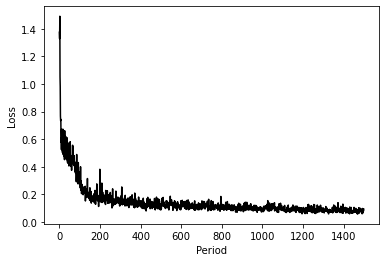

In [9]:
X_df = dataset.loc[:, ['WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B',
        'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2',
       'HWS_S26', 'PUMP_S26', 'MEAN_RAIN']]
y_df = dataset.loc[:, ['TWS_S25B']]
X = np.array(X_df)
y = np.array(y_df)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)


num_features = X.shape[1]
num_periods = len(X) // 8
X = np.asarray(X).reshape((-1, num_periods, num_features))
y = np.asarray(y).reshape((-1, num_periods))
print("X.shape, y.shape:", X.shape, y.shape)

quantiles = [0.1, 0.5, 1]  # 0.1, 0.5, 1
losses, test_mape, test_mae, test_rmse = train(X, y, quantiles)
#print(test_mape, test_mae, test_rmse)


print('====== MAPE, MAE, RMSE ======')
print(sum(test_mape) / len(test_mape),
      sum(test_mae) / len(test_mae), 
      sum(test_rmse) / len(test_rmse))


plt.plot(range(len(losses)), losses, "k-")
plt.xlabel("Period")
plt.ylabel("Loss")
plt.show()

X.shape, y.shape: (8, 12054, 15) (8, 12054)
(8, 9643, 15) (8, 9643) (8, 2411, 15) (8, 2411)
Epoch 0 start...
Epoch 1 start...
Epoch 2 start...
Epoch 3 start...


Epoch 4 start...
Epoch 5 start...
Epoch 6 start...
Epoch 7 start...


Epoch 8 start...
Epoch 9 start...
Epoch 10 start...
Epoch 11 start...


Epoch 12 start...
Epoch 13 start...
Epoch 14 start...
Epoch 15 start...


Epoch 16 start...
Epoch 17 start...
Epoch 18 start...
Epoch 19 start...


Epoch 20 start...
Epoch 21 start...
Epoch 22 start...
Epoch 23 start...


Epoch 24 start...
Epoch 25 start...
Epoch 26 start...
Epoch 27 start...


Epoch 28 start...
Epoch 29 start...
Epoch 30 start...
Epoch 31 start...


Epoch 32 start...
Epoch 33 start...
Epoch 34 start...
Epoch 35 start...


Epoch 36 start...
Epoch 37 start...
Epoch 38 start...
Epoch 39 start...


Epoch 40 start...
Epoch 41 start...
Epoch 42 start...
Epoch 43 start...


Epoch 44 start...
Epoch 45 start...
Epoch 46 start...
Epoch 47 start...


Epoch 48 start...
Epoch 49 start...
Epoch 50 start...
Epoch 51 start...


Epoch 52 start...
Epoch 53 start...
Epoch 54 start...
Epoch 55 start...


Epoch 56 start...
Epoch 57 start...
Epoch 58 start...
Epoch 59 start...


Epoch 60 start...
Epoch 61 start...
Epoch 62 start...
Epoch 63 start...


Epoch 64 start...
Epoch 65 start...
Epoch 66 start...
Epoch 67 start...


Epoch 68 start...
Epoch 69 start...
Epoch 70 start...
Epoch 71 start...


Epoch 72 start...
Epoch 73 start...
Epoch 74 start...
Epoch 75 start...


Epoch 76 start...
Epoch 77 start...
Epoch 78 start...
Epoch 79 start...


Epoch 80 start...
Epoch 81 start...
Epoch 82 start...
Epoch 83 start...


Epoch 84 start...
Epoch 85 start...
Epoch 86 start...
Epoch 87 start...


Epoch 88 start...
Epoch 89 start...
Epoch 90 start...
Epoch 91 start...


Epoch 92 start...
Epoch 93 start...
Epoch 94 start...
Epoch 95 start...


Epoch 96 start...
Epoch 97 start...
Epoch 98 start...
Epoch 99 start...


Epoch 100 start...
Epoch 101 start...
Epoch 102 start...
Epoch 103 start...


Epoch 104 start...
Epoch 105 start...
Epoch 106 start...
Epoch 107 start...


Epoch 108 start...
Epoch 109 start...
Epoch 110 start...
Epoch 111 start...


Epoch 112 start...
Epoch 113 start...
Epoch 114 start...
Epoch 115 start...


Epoch 116 start...
Epoch 117 start...
Epoch 118 start...
Epoch 119 start...


Epoch 120 start...
Epoch 121 start...
Epoch 122 start...
Epoch 123 start...


Epoch 124 start...
Epoch 125 start...
Epoch 126 start...
Epoch 127 start...


Epoch 128 start...
Epoch 129 start...
Epoch 130 start...
Epoch 131 start...


Epoch 132 start...
Epoch 133 start...
Epoch 134 start...
Epoch 135 start...


Epoch 136 start...
Epoch 137 start...
Epoch 138 start...
Epoch 139 start...


Epoch 140 start...
Epoch 141 start...
Epoch 142 start...
Epoch 143 start...


Epoch 144 start...
Epoch 145 start...
Epoch 146 start...
Epoch 147 start...


Epoch 148 start...
Epoch 149 start...
Epoch 150 start...
Epoch 151 start...


Epoch 152 start...
Epoch 153 start...
Epoch 154 start...
Epoch 155 start...


Epoch 156 start...
Epoch 157 start...
Epoch 158 start...
Epoch 159 start...


Epoch 160 start...
Epoch 161 start...
Epoch 162 start...
Epoch 163 start...


Epoch 164 start...
Epoch 165 start...
Epoch 166 start...
Epoch 167 start...


Epoch 168 start...
Epoch 169 start...
Epoch 170 start...
Epoch 171 start...


Epoch 172 start...
Epoch 173 start...
Epoch 174 start...
Epoch 175 start...


Epoch 176 start...
Epoch 177 start...
Epoch 178 start...
Epoch 179 start...


Epoch 180 start...
Epoch 181 start...
Epoch 182 start...
Epoch 183 start...


Epoch 184 start...
Epoch 185 start...
Epoch 186 start...
Epoch 187 start...


Epoch 188 start...
Epoch 189 start...
Epoch 190 start...
Epoch 191 start...


Epoch 192 start...
Epoch 193 start...
Epoch 194 start...
Epoch 195 start...


Epoch 196 start...
Epoch 197 start...
Epoch 198 start...
Epoch 199 start...


Epoch 200 start...
Epoch 201 start...
Epoch 202 start...
Epoch 203 start...


Epoch 204 start...
Epoch 205 start...
Epoch 206 start...
Epoch 207 start...


Epoch 208 start...
Epoch 209 start...
Epoch 210 start...
Epoch 211 start...


Epoch 212 start...
Epoch 213 start...
Epoch 214 start...
Epoch 215 start...


Epoch 216 start...
Epoch 217 start...
Epoch 218 start...
Epoch 219 start...


Epoch 220 start...
Epoch 221 start...
Epoch 222 start...
Epoch 223 start...


Epoch 224 start...
Epoch 225 start...
Epoch 226 start...
Epoch 227 start...


Epoch 228 start...
Epoch 229 start...
Epoch 230 start...
Epoch 231 start...


Epoch 232 start...
Epoch 233 start...
Epoch 234 start...
Epoch 235 start...


Epoch 236 start...
Epoch 237 start...
Epoch 238 start...
Epoch 239 start...


Epoch 240 start...
Epoch 241 start...
Epoch 242 start...
Epoch 243 start...


Epoch 244 start...
Epoch 245 start...
Epoch 246 start...
Epoch 247 start...


Epoch 248 start...
Epoch 249 start...
Epoch 250 start...
Epoch 251 start...


Epoch 252 start...
Epoch 253 start...
Epoch 254 start...
Epoch 255 start...


Epoch 256 start...
Epoch 257 start...
Epoch 258 start...
Epoch 259 start...


Epoch 260 start...
Epoch 261 start...
Epoch 262 start...
Epoch 263 start...


Epoch 264 start...
Epoch 265 start...
Epoch 266 start...
Epoch 267 start...


Epoch 268 start...
Epoch 269 start...
Epoch 270 start...
Epoch 271 start...


Epoch 272 start...
Epoch 273 start...
Epoch 274 start...
Epoch 275 start...


Epoch 276 start...
Epoch 277 start...
Epoch 278 start...
Epoch 279 start...


Epoch 280 start...
Epoch 281 start...
Epoch 282 start...
Epoch 283 start...


Epoch 284 start...
Epoch 285 start...
Epoch 286 start...
Epoch 287 start...


Epoch 288 start...
Epoch 289 start...
Epoch 290 start...
Epoch 291 start...


Epoch 292 start...
Epoch 293 start...
Epoch 294 start...
Epoch 295 start...


Epoch 296 start...
Epoch 297 start...
Epoch 298 start...
Epoch 299 start...


Epoch 300 start...
Epoch 314 start...
Epoch 315 start...


Epoch 316 start...
Epoch 317 start...
Epoch 318 start...
Epoch 319 start...


Epoch 320 start...
Epoch 321 start...
Epoch 322 start...
Epoch 323 start...


Epoch 324 start...
Epoch 325 start...
Epoch 326 start...
Epoch 327 start...


Epoch 328 start...
Epoch 329 start...
Epoch 330 start...
Epoch 331 start...


Epoch 332 start...
Epoch 333 start...
Epoch 334 start...
Epoch 335 start...


Epoch 336 start...
Epoch 337 start...
Epoch 338 start...
Epoch 339 start...


Epoch 340 start...
Epoch 341 start...
Epoch 342 start...
Epoch 343 start...


Epoch 344 start...
Epoch 345 start...
Epoch 346 start...
Epoch 347 start...


Epoch 348 start...
Epoch 349 start...
Epoch 350 start...
Epoch 351 start...


Epoch 352 start...
Epoch 353 start...
Epoch 354 start...
Epoch 355 start...


Epoch 356 start...
Epoch 357 start...
Epoch 358 start...
Epoch 359 start...


Epoch 360 start...
Epoch 361 start...
Epoch 362 start...
Epoch 363 start...


Epoch 364 start...
Epoch 365 start...
Epoch 366 start...
Epoch 367 start...


Epoch 368 start...
Epoch 369 start...
Epoch 370 start...
Epoch 371 start...


Epoch 372 start...
Epoch 373 start...
Epoch 374 start...
Epoch 375 start...


Epoch 376 start...
Epoch 377 start...
Epoch 378 start...
Epoch 379 start...


Epoch 380 start...
Epoch 381 start...
Epoch 382 start...
Epoch 383 start...


Epoch 384 start...
Epoch 385 start...
Epoch 386 start...
Epoch 387 start...


Epoch 388 start...
Epoch 389 start...
Epoch 390 start...
Epoch 391 start...


Epoch 392 start...
Epoch 393 start...
Epoch 394 start...
Epoch 395 start...


Epoch 396 start...
Epoch 397 start...
Epoch 398 start...
Epoch 399 start...


Epoch 400 start...
Epoch 401 start...
Epoch 402 start...
Epoch 403 start...


Epoch 404 start...
Epoch 405 start...
Epoch 406 start...
Epoch 407 start...


Epoch 408 start...
Epoch 409 start...
Epoch 410 start...
Epoch 411 start...


Epoch 412 start...
Epoch 413 start...
Epoch 414 start...
Epoch 415 start...


Epoch 416 start...
Epoch 417 start...
Epoch 418 start...
Epoch 419 start...


Epoch 420 start...
Epoch 421 start...
Epoch 422 start...
Epoch 423 start...


Epoch 424 start...
Epoch 425 start...
Epoch 426 start...
Epoch 427 start...


Epoch 428 start...
Epoch 429 start...
Epoch 430 start...
Epoch 431 start...


Epoch 432 start...
Epoch 433 start...
Epoch 434 start...
Epoch 435 start...


Epoch 436 start...
Epoch 437 start...
Epoch 438 start...
Epoch 439 start...


Epoch 440 start...
Epoch 441 start...
Epoch 442 start...
Epoch 443 start...


Epoch 444 start...
Epoch 445 start...
Epoch 446 start...
Epoch 447 start...


Epoch 448 start...
Epoch 449 start...
Epoch 450 start...
Epoch 451 start...


Epoch 452 start...
Epoch 453 start...
Epoch 454 start...
Epoch 455 start...


Epoch 456 start...
Epoch 457 start...
Epoch 458 start...
Epoch 459 start...


Epoch 460 start...
Epoch 461 start...
Epoch 462 start...
Epoch 463 start...


Epoch 464 start...
Epoch 465 start...
Epoch 466 start...
Epoch 467 start...


Epoch 468 start...
Epoch 469 start...
Epoch 470 start...
Epoch 471 start...


Epoch 472 start...
Epoch 473 start...
Epoch 474 start...
Epoch 475 start...


Epoch 476 start...
Epoch 477 start...
Epoch 478 start...
Epoch 479 start...


Epoch 480 start...
Epoch 481 start...
Epoch 482 start...
Epoch 483 start...


Epoch 484 start...
Epoch 485 start...
Epoch 486 start...
Epoch 487 start...


Epoch 488 start...
Epoch 489 start...
Epoch 490 start...
Epoch 491 start...


Epoch 492 start...
Epoch 493 start...
Epoch 494 start...
Epoch 495 start...


Epoch 496 start...
Epoch 497 start...
Epoch 498 start...
Epoch 499 start...


100% |######################################################################################################################################################|


Prediction: 0
Prediction: 1
Prediction: 2
Prediction: 3
Prediction: 4
Prediction: 5
Prediction: 6
Prediction: 7
Prediction: 8
Prediction: 9
Prediction: 10
Prediction: 11
Prediction: 12
Prediction: 13
Prediction: 14
Prediction: 15
Prediction: 16
Prediction: 17
Prediction: 18
Prediction: 19
Prediction: 20
Prediction: 21
Prediction: 22
Prediction: 23
Prediction: 24
Prediction: 25
Prediction: 26
Prediction: 27
Prediction: 28
Prediction: 29
Prediction: 30
Prediction: 31
Prediction: 32
Prediction: 33
Prediction: 34
Prediction: 35
Prediction: 36
Prediction: 37
Prediction: 38
Prediction: 39
Prediction: 40
Prediction: 41
Prediction: 42
Prediction: 43
Prediction: 44
Prediction: 45
Prediction: 46
Prediction: 47
Prediction: 48
Prediction: 49


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 50
Prediction: 51


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 52
Prediction: 53
Prediction: 54


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 55
Prediction: 56
Prediction: 57
Prediction: 58


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 59
Prediction: 60
Prediction: 61


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 62
Prediction: 63
Prediction: 64


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 65
Prediction: 66
Prediction: 67
Prediction: 68
Prediction: 69
Prediction: 70
Prediction: 71
Prediction: 72
Prediction: 73
Prediction: 74
Prediction: 75
Prediction: 76
Prediction: 77
Prediction: 78
Prediction: 79
Prediction: 80
Prediction: 81
Prediction: 82
Prediction: 83
Prediction: 84
Prediction: 85
Prediction: 86
Prediction: 87


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 88
Prediction: 89


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 90
Prediction: 91


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 92
Prediction: 93


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 94
Prediction: 95


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 96
Prediction: 97


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 98
Prediction: 99
Prediction: 100
Prediction: 101


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 102
Prediction: 103
Prediction: 104
Prediction: 105
Prediction: 106
Prediction: 107
Prediction: 108
Prediction: 109
Prediction: 110
Prediction: 111
Prediction: 112
Prediction: 113
Prediction: 114
Prediction: 115
Prediction: 116
Prediction: 117
Prediction: 118
Prediction: 119
Prediction: 120
Prediction: 121
Prediction: 122
Prediction: 123
Prediction: 124
Prediction: 125
Prediction: 126
Prediction: 127
Prediction: 128
Prediction: 129
Prediction: 130
Prediction: 131
Prediction: 132
Prediction: 133
Prediction: 134
Prediction: 135
Prediction: 136
Prediction: 137
Prediction: 138
Prediction: 139
Prediction: 140
Prediction: 141
Prediction: 142
Prediction: 143
Prediction: 144
Prediction: 145
Prediction: 146
Prediction: 147


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 148


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 149
Prediction: 150
Prediction: 151


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 152
Prediction: 153
Prediction: 154


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 155


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 156
Prediction: 157
Prediction: 158
Prediction: 159
Prediction: 160
Prediction: 161
Prediction: 162
Prediction: 163
Prediction: 164
Prediction: 165
Prediction: 166
Prediction: 167
Prediction: 168
Prediction: 169
Prediction: 170
Prediction: 171
Prediction: 172
Prediction: 173
Prediction: 174
Prediction: 175
Prediction: 176
Prediction: 177
Prediction: 178
Prediction: 179


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 180
Prediction: 181


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 182
Prediction: 183
Prediction: 184


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 185
Prediction: 186
Prediction: 187


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 188


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 189


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 190
Prediction: 191
Prediction: 192
Prediction: 193
Prediction: 194
Prediction: 195
Prediction: 196
Prediction: 197
Prediction: 198
Prediction: 199
Prediction: 200
Prediction: 201
Prediction: 202
Prediction: 203


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 204


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 205
Prediction: 206
Prediction: 207


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 208
Prediction: 209


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 210
Prediction: 211
Prediction: 212


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 213
Prediction: 214
Prediction: 215
Prediction: 216
Prediction: 217
Prediction: 218
Prediction: 219
Prediction: 220
Prediction: 221
Prediction: 222
Prediction: 223
Prediction: 224
Prediction: 225
Prediction: 226
Prediction: 227
Prediction: 228
Prediction: 229
Prediction: 230
Prediction: 231
Prediction: 232
Prediction: 233
Prediction: 234
Prediction: 235
Prediction: 236
Prediction: 237
Prediction: 238
Prediction: 239
Prediction: 240
Prediction: 241
Prediction: 242
Prediction: 243
Prediction: 244
Prediction: 245
Prediction: 246
Prediction: 247
Prediction: 248
Prediction: 249
Prediction: 250
Prediction: 251
Prediction: 252
Prediction: 253
Prediction: 254
Prediction: 255
Prediction: 256
Prediction: 257
Prediction: 258
Prediction: 259
Prediction: 260
Prediction: 261
Prediction: 262
Prediction: 263
Prediction: 264
Prediction: 265
Prediction: 266
Prediction: 267
Prediction: 268
Prediction: 269
Prediction: 270
Prediction: 271
Prediction: 272
Prediction: 273
Prediction: 274
Predicti

/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 553
Prediction: 554
Prediction: 555


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 556
Prediction: 557


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 558
Prediction: 559
Prediction: 560


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 561


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 562
Prediction: 563
Prediction: 564


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 565
Prediction: 566
Prediction: 567
Prediction: 568


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 569
Prediction: 570


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 571
Prediction: 572


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 573
Prediction: 574
Prediction: 575
Prediction: 576
Prediction: 577
Prediction: 578
Prediction: 579
Prediction: 580


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 581
Prediction: 582


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 583
Prediction: 584


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 585


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 586
Prediction: 587


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 588
Prediction: 589


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 590
Prediction: 591


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 592
Prediction: 593
Prediction: 594
Prediction: 595
Prediction: 596
Prediction: 597
Prediction: 598
Prediction: 599
Prediction: 600
Prediction: 601
Prediction: 602
Prediction: 603
Prediction: 604
Prediction: 605
Prediction: 606
Prediction: 607


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 608
Prediction: 609
Prediction: 610


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 611


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 612
Prediction: 613
Prediction: 614


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 615
Prediction: 616


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 617
Prediction: 618
Prediction: 619
Prediction: 620
Prediction: 621
Prediction: 622
Prediction: 623
Prediction: 624
Prediction: 625
Prediction: 626
Prediction: 627
Prediction: 628
Prediction: 629
Prediction: 630
Prediction: 631
Prediction: 632
Prediction: 633
Prediction: 634
Prediction: 635
Prediction: 636
Prediction: 637
Prediction: 638
Prediction: 639
Prediction: 640
Prediction: 641
Prediction: 642
Prediction: 643
Prediction: 644
Prediction: 645
Prediction: 646
Prediction: 647
Prediction: 648
Prediction: 649
Prediction: 650
Prediction: 651
Prediction: 652
Prediction: 653
Prediction: 654
Prediction: 655
Prediction: 656
Prediction: 657
Prediction: 658
Prediction: 659
Prediction: 660
Prediction: 661
Prediction: 662
Prediction: 663
Prediction: 664
Prediction: 665
Prediction: 666
Prediction: 667
Prediction: 668
Prediction: 669
Prediction: 670
Prediction: 671
Prediction: 672
Prediction: 673
Prediction: 674
Prediction: 675
Prediction: 676
Prediction: 677
Prediction: 678
Predicti

/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 743
Prediction: 744
Prediction: 745
Prediction: 746


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 747
Prediction: 748


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 749
Prediction: 750


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 751
Prediction: 752


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 753


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 754
Prediction: 755
Prediction: 756
Prediction: 757
Prediction: 758


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 759
Prediction: 760


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 761
Prediction: 762


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 763


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 764
Prediction: 765


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 766
Prediction: 767


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 768
Prediction: 769
Prediction: 770
Prediction: 771
Prediction: 772
Prediction: 773
Prediction: 774
Prediction: 775
Prediction: 776
Prediction: 777
Prediction: 778
Prediction: 779
Prediction: 780
Prediction: 781
Prediction: 782
Prediction: 783
Prediction: 784
Prediction: 785
Prediction: 786
Prediction: 787
Prediction: 788
Prediction: 789
Prediction: 790
Prediction: 791
Prediction: 792
Prediction: 793
Prediction: 794
Prediction: 795
Prediction: 796
Prediction: 797
Prediction: 798
Prediction: 799
Prediction: 800
Prediction: 801
Prediction: 802
Prediction: 803
Prediction: 804
Prediction: 805
Prediction: 806
Prediction: 807
Prediction: 808
Prediction: 809
Prediction: 810
Prediction: 811
Prediction: 812
Prediction: 813
Prediction: 814
Prediction: 815
Prediction: 816
Prediction: 817
Prediction: 818
Prediction: 819
Prediction: 820
Prediction: 821
Prediction: 822
Prediction: 823
Prediction: 824
Prediction: 825
Prediction: 826
Prediction: 827
Prediction: 828
Prediction: 829
Predicti

/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 973
Prediction: 974
Prediction: 975
Prediction: 976


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 977
Prediction: 978
Prediction: 979


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 980
Prediction: 981
Prediction: 982


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 983
Prediction: 984
Prediction: 985
Prediction: 986
Prediction: 987
Prediction: 988
Prediction: 989
Prediction: 990
Prediction: 991
Prediction: 992
Prediction: 993
Prediction: 994
Prediction: 995
Prediction: 996
Prediction: 997
Prediction: 998
Prediction: 999
Prediction: 1000
Prediction: 1001
Prediction: 1002
Prediction: 1003
Prediction: 1004
Prediction: 1005
Prediction: 1006
Prediction: 1007
Prediction: 1008
Prediction: 1009


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1010
Prediction: 1011
Prediction: 1012


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1013
Prediction: 1014


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1015
Prediction: 1016
Prediction: 1017
Prediction: 1018
Prediction: 1019


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1020
Prediction: 1021
Prediction: 1022


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1023
Prediction: 1024


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1025
Prediction: 1026


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1027
Prediction: 1028
Prediction: 1029
Prediction: 1030


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1031
Prediction: 1032


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1033
Prediction: 1034
Prediction: 1035


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1036
Prediction: 1037
Prediction: 1038


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1039
Prediction: 1040
Prediction: 1041


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1042
Prediction: 1043
Prediction: 1044
Prediction: 1045
Prediction: 1046
Prediction: 1047
Prediction: 1048
Prediction: 1049
Prediction: 1050
Prediction: 1051
Prediction: 1052
Prediction: 1053
Prediction: 1054
Prediction: 1055
Prediction: 1056
Prediction: 1057
Prediction: 1058
Prediction: 1059
Prediction: 1060
Prediction: 1061
Prediction: 1062
Prediction: 1063
Prediction: 1064
Prediction: 1065
Prediction: 1066
Prediction: 1067
Prediction: 1068
Prediction: 1069
Prediction: 1070
Prediction: 1071
Prediction: 1072
Prediction: 1073
Prediction: 1074
Prediction: 1075
Prediction: 1076
Prediction: 1077
Prediction: 1078
Prediction: 1079
Prediction: 1080
Prediction: 1081
Prediction: 1082
Prediction: 1083
Prediction: 1084
Prediction: 1085
Prediction: 1086
Prediction: 1087
Prediction: 1088
Prediction: 1089
Prediction: 1090
Prediction: 1091
Prediction: 1092
Prediction: 1093
Prediction: 1094
Prediction: 1095
Prediction: 1096
Prediction: 1097
Prediction: 1098
Prediction: 1099
Prediction: 11

/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1227
Prediction: 1228


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1229
Prediction: 1230
Prediction: 1231
Prediction: 1232


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1233
Prediction: 1234
Prediction: 1235


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1236
Prediction: 1237
Prediction: 1238
Prediction: 1239
Prediction: 1240
Prediction: 1241
Prediction: 1242
Prediction: 1243
Prediction: 1244
Prediction: 1245
Prediction: 1246
Prediction: 1247
Prediction: 1248
Prediction: 1249
Prediction: 1250
Prediction: 1251
Prediction: 1252
Prediction: 1253
Prediction: 1254
Prediction: 1255


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1256
Prediction: 1257
Prediction: 1258


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1259
Prediction: 1260


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1261
Prediction: 1262
Prediction: 1263
Prediction: 1264


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1265
Prediction: 1266
Prediction: 1267
Prediction: 1268
Prediction: 1269
Prediction: 1270
Prediction: 1271
Prediction: 1272
Prediction: 1273
Prediction: 1274
Prediction: 1275
Prediction: 1276
Prediction: 1277
Prediction: 1278
Prediction: 1279
Prediction: 1280
Prediction: 1281
Prediction: 1282
Prediction: 1283
Prediction: 1284
Prediction: 1285
Prediction: 1286
Prediction: 1287
Prediction: 1288
Prediction: 1289
Prediction: 1290
Prediction: 1291
Prediction: 1292
Prediction: 1293
Prediction: 1294
Prediction: 1295
Prediction: 1296
Prediction: 1297
Prediction: 1298
Prediction: 1299
Prediction: 1300
Prediction: 1301
Prediction: 1302
Prediction: 1303
Prediction: 1304
Prediction: 1305
Prediction: 1306
Prediction: 1307
Prediction: 1308
Prediction: 1309
Prediction: 1310
Prediction: 1311
Prediction: 1312
Prediction: 1313
Prediction: 1314
Prediction: 1315
Prediction: 1316
Prediction: 1317
Prediction: 1318
Prediction: 1319
Prediction: 1320
Prediction: 1321
Prediction: 1322
Prediction: 13

/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1393
Prediction: 1394
Prediction: 1395
Prediction: 1396


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1397
Prediction: 1398
Prediction: 1399
Prediction: 1400


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1401
Prediction: 1402
Prediction: 1403


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1404
Prediction: 1405
Prediction: 1406
Prediction: 1407
Prediction: 1408
Prediction: 1409
Prediction: 1410
Prediction: 1411
Prediction: 1412
Prediction: 1413
Prediction: 1414
Prediction: 1415
Prediction: 1416
Prediction: 1417


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi0

Prediction: 1418
Prediction: 1419
Prediction: 1420


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1421
Prediction: 1422
Prediction: 1423


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1424
Prediction: 1425
Prediction: 1426
Prediction: 1427
Prediction: 1428
Prediction: 1429
Prediction: 1430
Prediction: 1431
Prediction: 1432
Prediction: 1433
Prediction: 1434
Prediction: 1435
Prediction: 1436
Prediction: 1437
Prediction: 1438
Prediction: 1439
Prediction: 1440
Prediction: 1441
Prediction: 1442
Prediction: 1443
Prediction: 1444
Prediction: 1445
Prediction: 1446
Prediction: 1447
Prediction: 1448
Prediction: 1449
Prediction: 1450
Prediction: 1451
Prediction: 1452
Prediction: 1453
Prediction: 1454
Prediction: 1455
Prediction: 1456
Prediction: 1457
Prediction: 1458
Prediction: 1459
Prediction: 1460
Prediction: 1461
Prediction: 1462
Prediction: 1463
Prediction: 1464
Prediction: 1465
Prediction: 1466
Prediction: 1467
Prediction: 1468
Prediction: 1469
Prediction: 1470
Prediction: 1471
Prediction: 1472
Prediction: 1473
Prediction: 1474
Prediction: 1475
Prediction: 1476
Prediction: 1477
Prediction: 1478
Prediction: 1479
Prediction: 1480
Prediction: 1481
Prediction: 14

/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1511
Prediction: 1512


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1513
Prediction: 1514


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1515
Prediction: 1516
Prediction: 1517
Prediction: 1518


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1519
Prediction: 1520
Prediction: 1521
Prediction: 1522
Prediction: 1523
Prediction: 1524
Prediction: 1525
Prediction: 1526
Prediction: 1527
Prediction: 1528
Prediction: 1529
Prediction: 1530
Prediction: 1531
Prediction: 1532
Prediction: 1533
Prediction: 1534
Prediction: 1535
Prediction: 1536
Prediction: 1537
Prediction: 1538
Prediction: 1539
Prediction: 1540
Prediction: 1541
Prediction: 1542
Prediction: 1543
Prediction: 1544
Prediction: 1545
Prediction: 1546
Prediction: 1547
Prediction: 1548
Prediction: 1549
Prediction: 1550
Prediction: 1551
Prediction: 1552
Prediction: 1553
Prediction: 1554
Prediction: 1555
Prediction: 1556
Prediction: 1557
Prediction: 1558
Prediction: 1559
Prediction: 1560
Prediction: 1561
Prediction: 1562
Prediction: 1563
Prediction: 1564
Prediction: 1565
Prediction: 1566
Prediction: 1567
Prediction: 1568
Prediction: 1569
Prediction: 1570
Prediction: 1571
Prediction: 1572
Prediction: 1573
Prediction: 1574
Prediction: 1575
Prediction: 1576
Prediction: 15

/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1914
Prediction: 1915
Prediction: 1916


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1917
Prediction: 1918
Prediction: 1919


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1920
Prediction: 1921
Prediction: 1922
Prediction: 1923


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1924
Prediction: 1925
Prediction: 1926
Prediction: 1927


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1928
Prediction: 1929
Prediction: 1930
Prediction: 1931


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1932
Prediction: 1933


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 1934
Prediction: 1935
Prediction: 1936
Prediction: 1937
Prediction: 1938
Prediction: 1939
Prediction: 1940
Prediction: 1941
Prediction: 1942
Prediction: 1943
Prediction: 1944
Prediction: 1945
Prediction: 1946
Prediction: 1947
Prediction: 1948
Prediction: 1949
Prediction: 1950
Prediction: 1951
Prediction: 1952
Prediction: 1953
Prediction: 1954
Prediction: 1955
Prediction: 1956
Prediction: 1957
Prediction: 1958
Prediction: 1959
Prediction: 1960
Prediction: 1961
Prediction: 1962
Prediction: 1963
Prediction: 1964
Prediction: 1965
Prediction: 1966
Prediction: 1967
Prediction: 1968
Prediction: 1969
Prediction: 1970
Prediction: 1971
Prediction: 1972
Prediction: 1973
Prediction: 1974
Prediction: 1975
Prediction: 1976
Prediction: 1977
Prediction: 1978
Prediction: 1979
Prediction: 1980
Prediction: 1981
Prediction: 1982
Prediction: 1983
Prediction: 1984
Prediction: 1985
Prediction: 1986
Prediction: 1987
Prediction: 1988
Prediction: 1989
Prediction: 1990
Prediction: 1991
Prediction: 19

/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2005
Prediction: 2006


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2007
Prediction: 2008
Prediction: 2009


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2010
Prediction: 2011


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2012
Prediction: 2013


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2014
Prediction: 2015
Prediction: 2016
Prediction: 2017
Prediction: 2018
Prediction: 2019
Prediction: 2020
Prediction: 2021
Prediction: 2022
Prediction: 2023
Prediction: 2024
Prediction: 2025
Prediction: 2026
Prediction: 2027
Prediction: 2028
Prediction: 2029
Prediction: 2030
Prediction: 2031
Prediction: 2032
Prediction: 2033
Prediction: 2034
Prediction: 2035
Prediction: 2036
Prediction: 2037
Prediction: 2038
Prediction: 2039
Prediction: 2040
Prediction: 2041
Prediction: 2042
Prediction: 2043
Prediction: 2044
Prediction: 2045
Prediction: 2046
Prediction: 2047
Prediction: 2048
Prediction: 2049
Prediction: 2050
Prediction: 2051
Prediction: 2052
Prediction: 2053
Prediction: 2054
Prediction: 2055
Prediction: 2056
Prediction: 2057
Prediction: 2058
Prediction: 2059
Prediction: 2060
Prediction: 2061
Prediction: 2062
Prediction: 2063
Prediction: 2064
Prediction: 2065
Prediction: 2066


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2067
Prediction: 2068
Prediction: 2069


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2070
Prediction: 2071


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2072
Prediction: 2073


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2074
Prediction: 2075
Prediction: 2076


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2077
Prediction: 2078
Prediction: 2079
Prediction: 2080
Prediction: 2081
Prediction: 2082
Prediction: 2083
Prediction: 2084
Prediction: 2085
Prediction: 2086


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2087
Prediction: 2088


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2089
Prediction: 2090
Prediction: 2091
Prediction: 2092
Prediction: 2093


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2094
Prediction: 2095
Prediction: 2096
Prediction: 2097
Prediction: 2098
Prediction: 2099
Prediction: 2100
Prediction: 2101
Prediction: 2102
Prediction: 2103
Prediction: 2104
Prediction: 2105
Prediction: 2106
Prediction: 2107
Prediction: 2108
Prediction: 2109
Prediction: 2110
Prediction: 2111
Prediction: 2112
Prediction: 2113
Prediction: 2114
Prediction: 2115
Prediction: 2116
Prediction: 2117
Prediction: 2118
Prediction: 2119
Prediction: 2120
Prediction: 2121
Prediction: 2122
Prediction: 2123
Prediction: 2124
Prediction: 2125
Prediction: 2126
Prediction: 2127
Prediction: 2128
Prediction: 2129
Prediction: 2130
Prediction: 2131
Prediction: 2132
Prediction: 2133
Prediction: 2134
Prediction: 2135
Prediction: 2136
Prediction: 2137
Prediction: 2138
Prediction: 2139
Prediction: 2140
Prediction: 2141
Prediction: 2142
Prediction: 2143
Prediction: 2144
Prediction: 2145
Prediction: 2146
Prediction: 2147
Prediction: 2148
Prediction: 2149
Prediction: 2150
Prediction: 2151
Prediction: 21

/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2186
Prediction: 2187
Prediction: 2188


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2189
Prediction: 2190
Prediction: 2191


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2192
Prediction: 2193
Prediction: 2194


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2195
Prediction: 2196
Prediction: 2197
Prediction: 2198
Prediction: 2199
Prediction: 2200
Prediction: 2201
Prediction: 2202
Prediction: 2203
Prediction: 2204
Prediction: 2205
Prediction: 2206
Prediction: 2207
Prediction: 2208
Prediction: 2209
Prediction: 2210
Prediction: 2211
Prediction: 2212
Prediction: 2213
Prediction: 2214
Prediction: 2215
Prediction: 2216
Prediction: 2217
Prediction: 2218
Prediction: 2219
Prediction: 2220
Prediction: 2221
Prediction: 2222
Prediction: 2223
Prediction: 2224
Prediction: 2225
Prediction: 2226
Prediction: 2227
Prediction: 2228
Prediction: 2229
Prediction: 2230
Prediction: 2231
Prediction: 2232
Prediction: 2233
Prediction: 2234
Prediction: 2235
Prediction: 2236
Prediction: 2237
Prediction: 2238
Prediction: 2239
Prediction: 2240
Prediction: 2241
Prediction: 2242
Prediction: 2243
Prediction: 2244
Prediction: 2245
Prediction: 2246
Prediction: 2247
Prediction: 2248
Prediction: 2249
Prediction: 2250
Prediction: 2251
Prediction: 2252
Prediction: 22

/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi0

Prediction: 2288
Prediction: 2289
Prediction: 2290
Prediction: 2291
Prediction: 2292


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2293
Prediction: 2294
Prediction: 2295


/aul/homes/jshi008/IvyProjects/ICLR/02MQRNN/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2296
Prediction: 2297
Prediction: 2298
Prediction: 2299
Prediction: 2300
Prediction: 2301
Prediction: 2302
Prediction: 2303
Prediction: 2304
Prediction: 2305
Prediction: 2306
Prediction: 2307
Prediction: 2308
Prediction: 2309
Prediction: 2310
Prediction: 2311
Prediction: 2312
Prediction: 2313
Prediction: 2314
Prediction: 2315
Prediction: 2316
Prediction: 2317
Prediction: 2318
Prediction: 2319
Prediction: 2320
Prediction: 2321
Prediction: 2322
Prediction: 2323
Prediction: 2324
Prediction: 2325
Prediction: 2326
====== MAPE, MAE, RMSE ======
inf 0.09521541706276368 0.1265578731823485


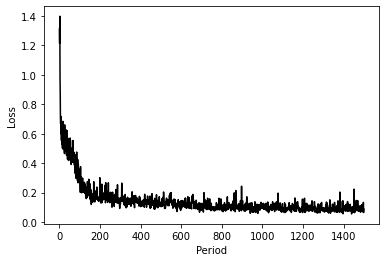

In [10]:
X_df = dataset.loc[:, ['WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B',
        'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2',
       'HWS_S26', 'PUMP_S26', 'MEAN_RAIN']]
y_df = dataset.loc[:, ['TWS_S26']]
X = np.array(X_df)
y = np.array(y_df)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)


num_features = X.shape[1]
num_periods = len(X) // 8
X = np.asarray(X).reshape((-1, num_periods, num_features))
y = np.asarray(y).reshape((-1, num_periods))
print("X.shape, y.shape:", X.shape, y.shape)

quantiles = [0.1, 0.5, 1]  # 0.1, 0.5, 1
losses, test_mape, test_mae, test_rmse = train(X, y, quantiles)
#print(test_mape, test_mae, test_rmse)


print('====== MAPE, MAE, RMSE ======')
print(sum(test_mape) / len(test_mape),
      sum(test_mae) / len(test_mae), 
      sum(test_rmse) / len(test_rmse))


plt.plot(range(len(losses)), losses, "k-")
plt.xlabel("Period")
plt.ylabel("Loss")
plt.show()